In [1]:
# imports

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorly as tl
from sklearn.decomposition import PCA
import umap
import xarray as xr


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 100

# keywargs for annotating panels
annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 22, 'annotation_clip': False
}


In [3]:
# helpful functions

# function to calculate 0-sensitive geometric mean
def geometric_mean(vector, pseudocount=1):
    return np.exp(np.mean(np.log(vector + pseudocount))) - pseudocount


# Read in data

In [4]:
# read in sample metadata

filepath_sample_metadata = '../../data/metadata/sample-metadata.csv'
sample_df = pd.read_csv(filepath_sample_metadata)
sample_df['Cruise'] = sample_df['Cruise'].map({'kok1606': 'G1', 
                                               'mgl1704': 'G2', 
                                               'km1906': 'G3'})
sample_df = sample_df.rename(columns={'SampleID': 'Sample'})

sample_df


Sample Cruise               Dataset Experiment  Station  \
0    G1.SURF.NS.S02C1.15m.A     G1   Gradients 1 surface        NaN      2.0   
1    G1.SURF.NS.S02C1.15m.B     G1   Gradients 1 surface        NaN      2.0   
2    G1.SURF.NS.S02C1.15m.C     G1   Gradients 1 surface        NaN      2.0   
3    G1.SURF.NS.S04C1.15m.A     G1   Gradients 1 surface        NaN      4.0   
4    G1.SURF.NS.S04C1.15m.B     G1   Gradients 1 surface        NaN      4.0   
..                      ...    ...                   ...        ...      ...   
217    G3.UW.NS.UW40_1.7m.B     G3  Gradients 3 underway        NaN      NaN   
218    G3.UW.NS.UW40_1.7m.C     G3  Gradients 3 underway        NaN      NaN   
219    G3.UW.NS.UW40_2.7m.A     G3  Gradients 3 underway        NaN      NaN   
220    G3.UW.NS.UW40_2.7m.B     G3  Gradients 3 underway        NaN      NaN   
221    G3.UW.NS.UW40_2.7m.C     G3  Gradients 3 underway        NaN      NaN   

     Cast      Datetime   Latitude   Longitude  Depth Replicate  \
0     1.0  4/20/16 5:51  23.495833 -157.994333     15         A   
1     1.0  4/20/16 5:51  23.495833 -157.994333     15         B   
2     1.0  4/20/16 5:51  23.495833 -157.994333     15         C   
3     1.0  4/22/16 5:40  28.143167 -158.000667     15         A   
4     1.0  4/22/16 5:40  28.143167 -158.000667     15         B   
..    ...           ...        ...         ...    ...       ...   
217   NaN  4/24/19 5:57  40.880000 -158.000000      7         B   
218   NaN  4/24/19 5:57  40.880000 -158.000000      7         C   
219   NaN  4/25/19 6:01  40.090000 -158.000000      7         A   
220   NaN  4/25/19 6:01  40.090000 -158.000000      7         B   
221   NaN  4/25/19 6:01  40.090000 -158.000000      7         C   

                    SmallFraction               LargeFraction  Unfractionated  \
0    G1.SURF.NS.S02C1.15m.0_2um.A  G1.SURF.NS.S02C1.15m.3um.A           False   
1    G1.SURF.NS.S02C1.15m.0_2um.B  G1.SURF.NS.S02C1.15m.3um.B           False   
2    G1.SURF.NS.S02C1.15m.0_2um.C  G1.SURF.NS.S02C1.15m.3um.C           False   
3    G1.SURF.NS.S04C1.15m.0_2um.A  G1.SURF.NS.S04C1.15m.3um.A           False   
4    G1.SURF.NS.S04C1.15m.0_2um.B  G1.SURF.NS.S04C1.15m.3um.B           False   
..                            ...                         ...             ...   
217    G3.UW.NS.UW40_1.7m.0_2um.B    G3.UW.NS.UW40_1.7m.3um.B           False   
218    G3.UW.NS.UW40_1.7m.0_2um.C    G3.UW.NS.UW40_1.7m.3um.C           False   
219    G3.UW.NS.UW40_2.7m.0_2um.A    G3.UW.NS.UW40_2.7m.3um.A           False   
220    G3.UW.NS.UW40_2.7m.0_2um.B    G3.UW.NS.UW40_2.7m.3um.B           False   
221    G3.UW.NS.UW40_2.7m.0_2um.C    G3.UW.NS.UW40_2.7m.3um.C           False   

       Batch  
0    G1_SURF  
1    G1_SURF  
2    G1_SURF  
3    G1_SURF  
4    G1_SURF  
..       ...  
217  G3_SURF  
218  G3_SURF  
219  G3_SURF  
220  G3_SURF  
221  G3_SURF  

[222 rows x 15 columns]

In [5]:
# read in normalized data

syn_ds = xr.open_dataset('../../data/3-normalization/syn-tensor-dataset.nc')
pro_ds = xr.open_dataset('../../data/3-normalization/pro-tensor-dataset.nc')

pro_ds


<xarray.Dataset>
Dimensions:     (Ortholog: 5023, Clade: 3, Sample: 175)
Coordinates:
  * Ortholog    (Ortholog) int64 60000001 60000002 ... 60040287 60040292
  * Clade       (Clade) object 'HLI' 'HLII' 'LLI'
  * Sample      (Sample) object 'G1.SURF.NS.S02C1.15m.A' ... 'G3.UW.NS.UW40_2...
Data variables:
    ReadCount   (Ortholog, Clade, Sample) float64 ...
    Residual    (Ortholog, Clade, Sample) float64 ...
    Replicate   (Sample) object ...
    SampleName  (Sample) object ...
    Annotation  (Ortholog) object ...

# Pre-normalization mean-variance relationship

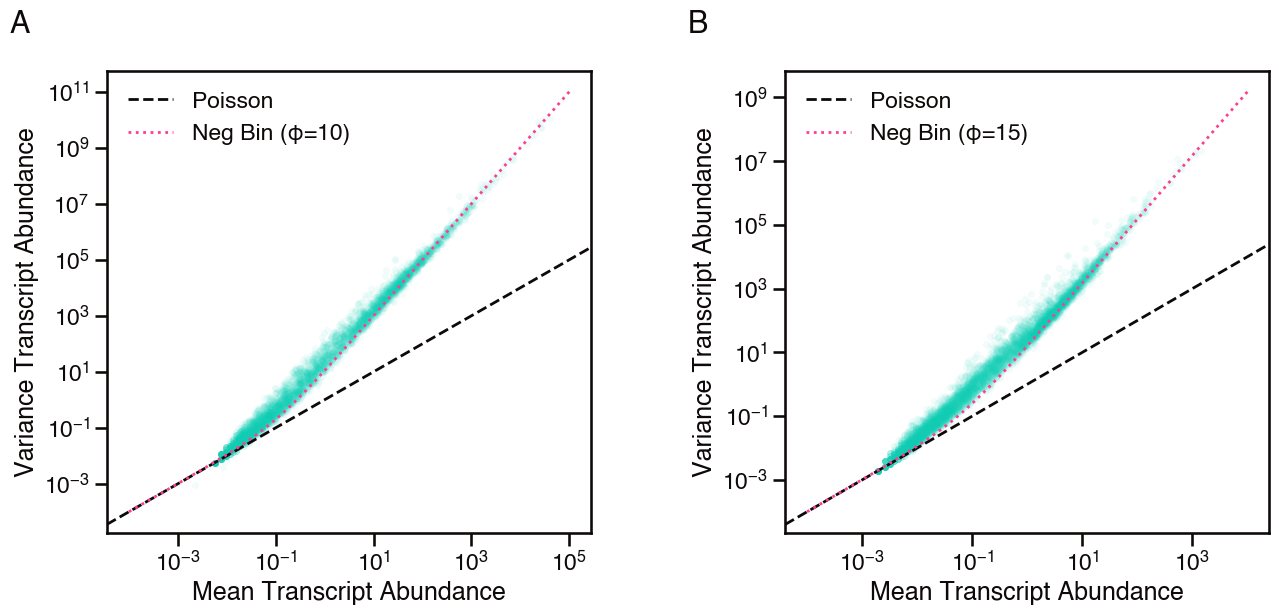

In [6]:
# make figure showing mean-variance relationship of pro and syn data

fig, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'wspace': .4})

# pull out prochlorococcus read abundance data (pre-normalization)
pro_abun_df = pro_ds.ReadCount.to_dataframe().reset_index()
pro_abun_df = pro_abun_df.pivot(index='Ortholog', columns=['Sample', 'Clade'], values='ReadCount')
# set negative binomial parameters
phi = 10
xx = np.logspace(-4, 5, num=248)
yy = xx + phi * np.power(xx, 2)
# plot mean vs. variance scatterplot
sns.scatterplot(
    x=pro_abun_df.mean(axis=1), 
    y=pro_abun_df.var(axis=1), 
    alpha=0.05, 
    s=20, 
    edgecolors=None, 
    color=sns.color_palette()[2], 
    legend=False, 
    ax=axes[0]
)
# plot poisson reference line
axes[0].axline((0, 0), slope=1, linestyle='--', color=sns.color_palette()[4], label='Poisson');
# plot negative binomial reference line
axes[0].plot(xx, yy, linestyle=':', color=sns.color_palette()[3], label='Neg Bin (φ={})'.format(phi));
# set figure parameters and labels
axes[0].annotate('A', xy=(-0.2, 1.1), **annot_kwgs)
axes[0].set(xscale='log', yscale='log', xlabel='Mean Transcript Abundance', ylabel='Variance Transcript Abundance')
axes[0].legend()


# pull out synechococcus read abundance data (pre-normalization)
syn_abun_df = syn_ds.ReadCount.to_dataframe().reset_index()
syn_abun_df = syn_abun_df.pivot(index='Ortholog', columns=['Sample', 'Clade'], values='ReadCount')
# set negative binomial parameters
phi = 15
xx = np.logspace(-4, 4, num=248)
yy = xx + phi * np.power(xx, 2)
# plot mean vs. variance scatterplot
sns.scatterplot(
    x=syn_abun_df.mean(axis=1), 
    y=syn_abun_df.var(axis=1), 
    alpha=0.05, 
    s=20, 
    edgecolors=None, 
    color=sns.color_palette()[2], 
    legend=False, 
    ax=axes[1]
)
# plot poisson reference line
axes[1].axline((0, 0), slope=1, linestyle='--', color=sns.color_palette()[4], label='Poisson');
# plot negative binomial reference line
axes[1].plot(xx, yy, linestyle=':', color=sns.color_palette()[3], label='Neg Bin (φ={})'.format(phi));
# set figure parameters and labels
axes[1].annotate('B', xy=(-0.2, 1.1), **annot_kwgs)
axes[1].set(xscale='log', yscale='log', xlabel='Mean Transcript Abundance', ylabel='Variance Transcript Abundance')
axes[1].legend()

plt.savefig('prenorm-var-v-mean.png', bbox_inches='tight')


# Post-normalization mean-variance relationship

In [7]:
# figure showing post-normalization mean-variance relationship
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True, gridspec_kw={'hspace': .3})

# prochlorococcus
ds = pro_ds
# iterate through clades
for i, clade in enumerate(ds.Clade.data):
    abundance = ds.sel(Clade=clade).ReadCount.to_pandas()
    residual = ds.sel(Clade=clade).Residual.to_pandas()
    abundance = abundance.loc[~residual.eq(0).all(axis=1), ~residual.eq(0).all()]
    residual = residual.loc[~residual.eq(0).all(axis=1), ~residual.eq(0).all()]
    sns.scatterplot(
        x=abundance.apply(geometric_mean, axis=1), 
        y=residual.var(axis=1), 
        alpha=0.5, 
        s=20, 
        edgecolors=None, 
        color=sns.color_palette()[i], 
        label=clade, 
        legend=False, 
        ax=axes[0]
    )
# set figure parameters and labels
axes[0].annotate('A', xy=(-0.1, 1.1), **annot_kwgs)
axes[0].set(xscale='log', ylabel='Residual Variance')
axes[0].legend(loc='upper left', fontsize=14)


# synechococcus
ds = syn_ds
# iterate through clades
colors = [sns.color_palette()[i] for i in [0, 1, 2, 3, 4, 6, 7]]
for i, clade in enumerate(ds.Clade.data):
    abundance = ds.sel(Clade=clade).ReadCount.to_pandas()
    residual = ds.sel(Clade=clade).Residual.to_pandas()
    abundance = abundance.loc[~residual.eq(0).all(axis=1), ~residual.eq(0).all()]
    residual = residual.loc[~residual.eq(0).all(axis=1), ~residual.eq(0).all()]
    sns.scatterplot(
        x=abundance.apply(geometric_mean, axis=1), 
        y=residual.var(axis=1), 
        alpha=0.5, 
        s=20, 
        edgecolors=None, 
        color=colors[i], 
        label=clade, 
        legend=False, 
        ax=axes[1]
    )
# set figure parameters and labels
axes[1].annotate('B', xy=(-0.1, 1.1), **annot_kwgs)
axes[1].set(xscale='log', xlabel='Mean Transcript Abundance', ylabel='residual variance')
axes[1].legend(loc='upper left', fontsize=14)

plt.savefig('postnorm-var-v-mean.png', bbox_inches='tight')


In [8]:
syn_ds.Clade

<xarray.DataArray 'Clade' (Clade: 7)>
array(['5.1A-CRD2', '5.1A-II', '5.1A-III', '5.1A-IV', '5.1A-UC-A-EnvC',
       '5.1B-CRD1', '5.1B-I'], dtype=object)
Coordinates:
  * Clade    (Clade) object '5.1A-CRD2' '5.1A-II' ... '5.1B-CRD1' '5.1B-I'

# Post-normalization UMAP analysis

In [9]:
# make dataframes from data tensors

# unfold syn residuals into dataframe
syn_df = syn_ds.Residual.to_dataframe().reset_index().pivot(
    index='Sample', 
    columns=['Ortholog', 'Clade']
)

# unfold pro residuals into dataframe
pro_df = pro_ds.Residual.to_dataframe().reset_index().pivot(
    index='Sample', 
    columns=['Ortholog', 'Clade']
)

residual_dfs = {
    'pro': pro_df, 
    'syn': syn_df
}


In [10]:
# take slices of each ecotype

residual_dfs = {}
readcount_dfs = {}
read_counts = {}
coverages = {}

for cyano in ['pro', 'syn']:
    if cyano == 'pro':
        clades = ['HLI', 'HLII', 'LLI']
        ds = pro_ds
    elif cyano == 'syn':
        clades = ['5.1A-CRD2', '5.1A-II', '5.1A-III', '5.1A-IV', '5.1A-UC-A-EnvC', '5.1B-CRD1', '5.1B-I']
        ds = syn_ds
    for clade in clades:
        slice_df = ds.sel(Clade=clade).Residual.to_dataframe().reset_index().pivot(
            index='Sample', columns='Ortholog', values='Residual')
        residual_dfs[clade] = slice_df[slice_df.sum(axis=1) != 0]
        # get read counts
        readcount_df = ds.sel(Clade=clade).ReadCount.to_dataframe().reset_index().pivot(
            index='Sample', columns='Ortholog', values='ReadCount')
        readcount_dfs[clade] = readcount_df[readcount_df.sum(axis=1) != 0]
        readcount = readcount_df.sum(axis=1)
        readcount.name = 'ReadCount'
        read_counts[clade] = readcount[readcount != 0]
        # get coverages
        coverage = readcount_df.gt(0).mean(axis=1)
        coverage.name = 'Coverage'
        coverages[clade] = coverage[coverage != 0]
    
# for clade in :
#     slice_df = pro_ds.sel(clade=clade).residual.to_dataframe().reset_index().pivot(
#         index='sample', columns='ortholog', values='residual')
#     residual_dfs[clade] = slice_df[slice_df.sum(axis=1) != 0]
#     # get read counts
#     readcount = pro_ds.sel(clade=clade).readcount.to_dataframe().reset_index().pivot(
#         index='sample', columns='ortholog', values='readcount').sum(axis=1)
#     readcount.name = 'ReadCount'
#     read_counts[clade] = readcount[readcount != 0]
#     # get coverages
#     coverage = pro_ds.sel(clade=clade).readcount.to_dataframe().reset_index().pivot(
#         index='sample', columns='ortholog', values='readcount').gt(0).mean(axis=1)
#     coverage.name = 'Coverage'
#     coverages[clade] = coverage[coverage != 0]
    

In [11]:
# UMAP of PCA

# parameters
n_comp_pca = 20
n_comp_umap = 2
seed = 9481 + 4

reduced_dfs = {}

for clade in ['HLI', 'HLII', 'LLI', '5.1A-CRD2', '5.1A-II', '5.1A-III', '5.1A-IV', '5.1A-UC-A-EnvC', '5.1B-CRD1', '5.1B-I']:
    print('\n{}'.format(clade))
    
    for dataset in ['Prenorm', 'Postnorm']:
        print('{} dataset'.format(dataset))
        if dataset == 'Prenorm':  
            input_df = readcount_dfs[clade]
        elif dataset == 'Postnorm':
            input_df = residual_dfs[clade]

        # run PCA
        print('\tRunning PCA with {} components...'.format(n_comp_pca))
        pca_model = PCA(n_components=n_comp_pca, random_state=seed)
        embedding = pca_model.fit_transform(input_df)

        # run UMAP
        print('\tRunning UMAP with {} components...'.format(n_comp_umap))
        umap_model = umap.UMAP(n_components=n_comp_umap, random_state=seed)
        # embedding = umap_model.fit_transform(input_df)
        embedding = umap_model.fit_transform(embedding)
        embedding_df = pd.DataFrame(embedding, index=input_df.index)
        
        # merge on metadata
        if dataset == 'Prenorm':
            embedding_df = embedding_df.rename(columns={0: 'Prenorm0', 1: 'Prenorm1'})
            merged_df = pd.merge(embedding_df.reset_index(), sample_df, on='Sample', how='left')
            # Add total read counts & coverages to merged_df
            merged_df['ReadCount'] = merged_df['Sample'].map(read_counts[clade])
            merged_df['Coverage'] = merged_df['Sample'].map(coverages[clade])
            
        elif dataset == 'Postnorm':
            embedding_df = embedding_df.rename(columns={0: 'Postnorm0', 1: 'Postnorm1'})
            merged_df = pd.merge(merged_df, embedding_df.reset_index(), on='Sample', how='left')

    # save to dictionary
    reduced_dfs[clade] = merged_df



HLI
Prenorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Postnorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



HLII
Prenorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Postnorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



LLI
Prenorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Postnorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



5.1A-CRD2
Prenorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Postnorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



5.1A-II
Prenorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Postnorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



5.1A-III
Prenorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Postnorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



5.1A-IV
Prenorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Postnorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



5.1A-UC-A-EnvC
Prenorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Postnorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



5.1B-CRD1
Prenorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Postnorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



5.1B-I
Prenorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Postnorm dataset
	Running PCA with 20 components...
	Running UMAP with 2 components...


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



HLI



HLII


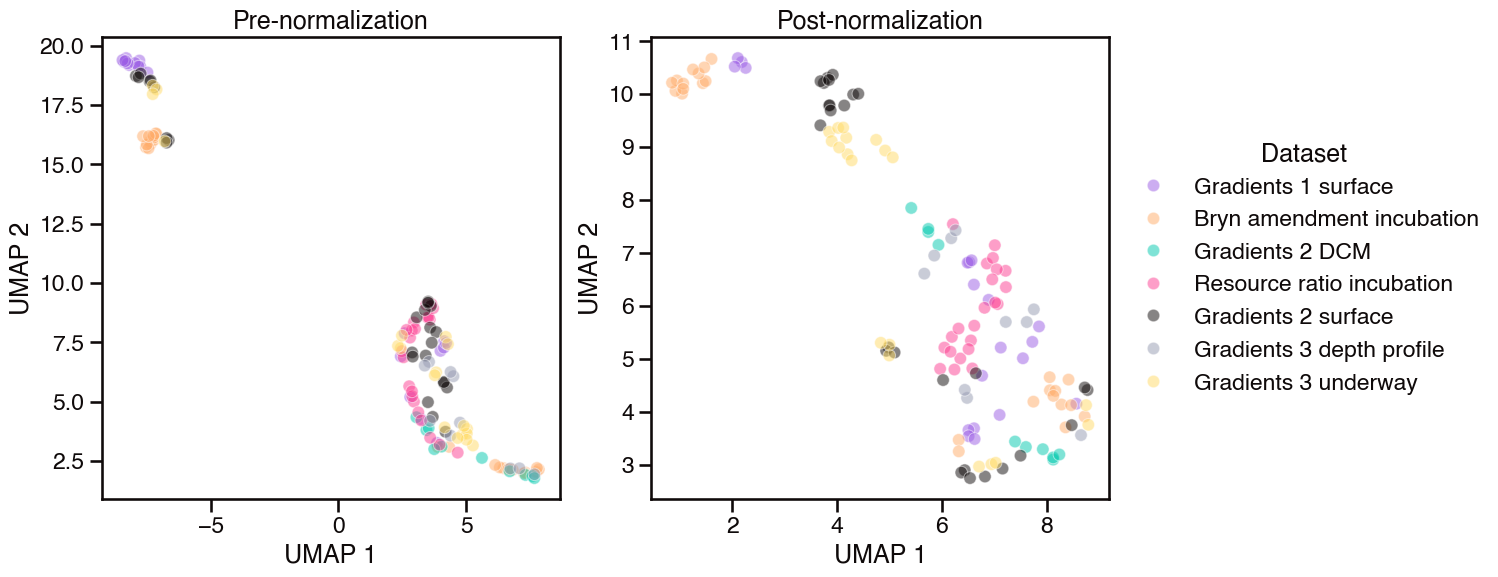

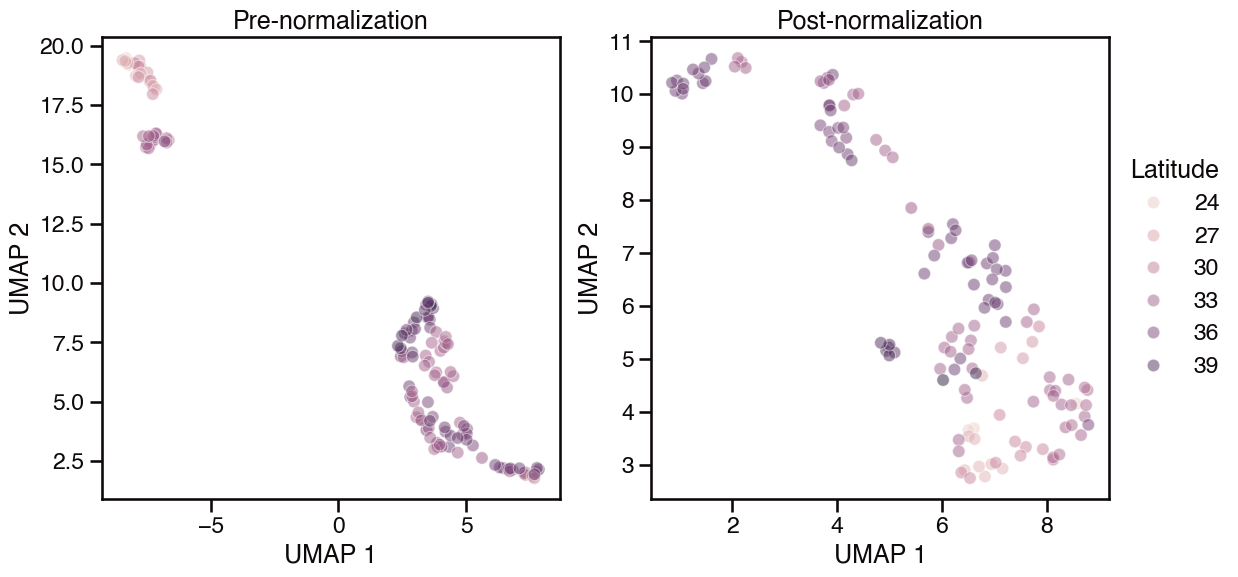

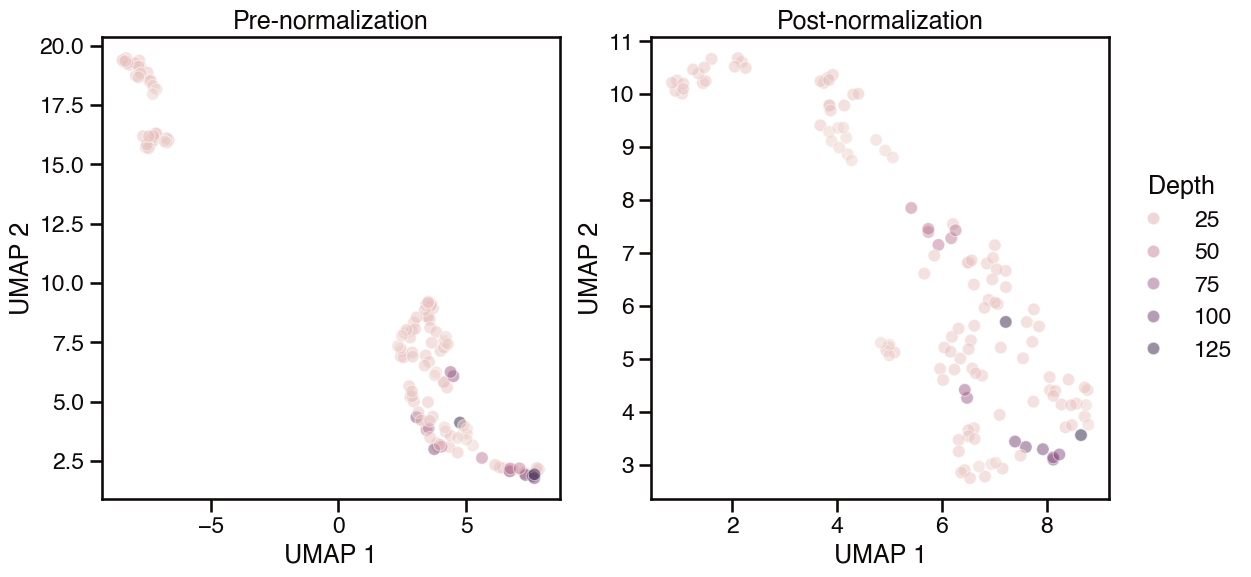

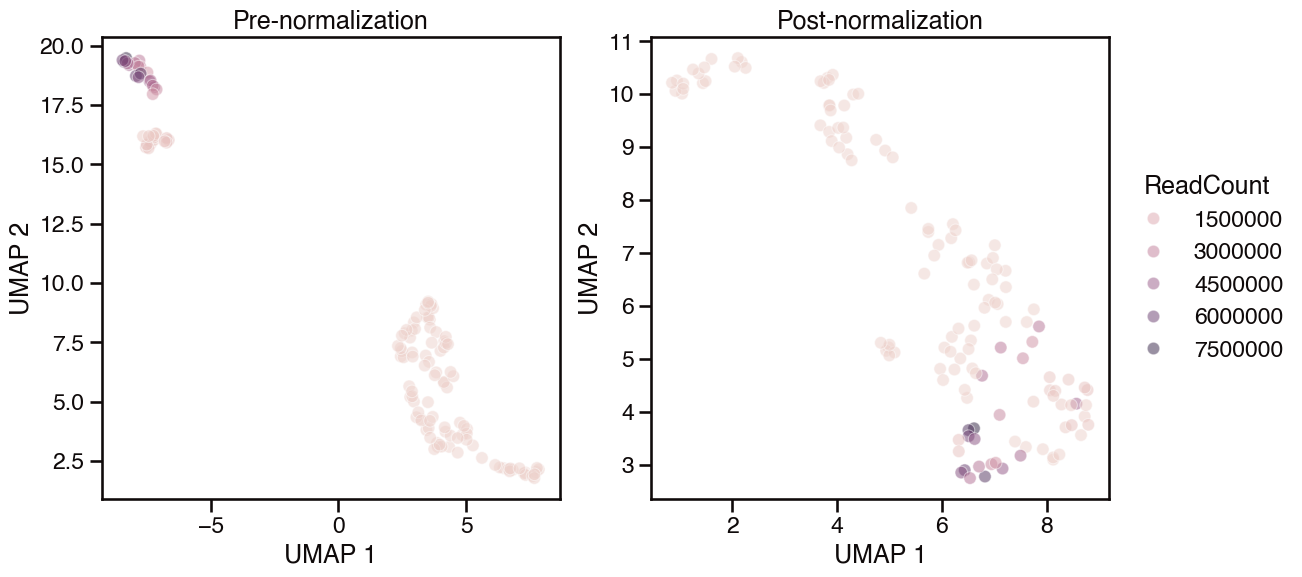

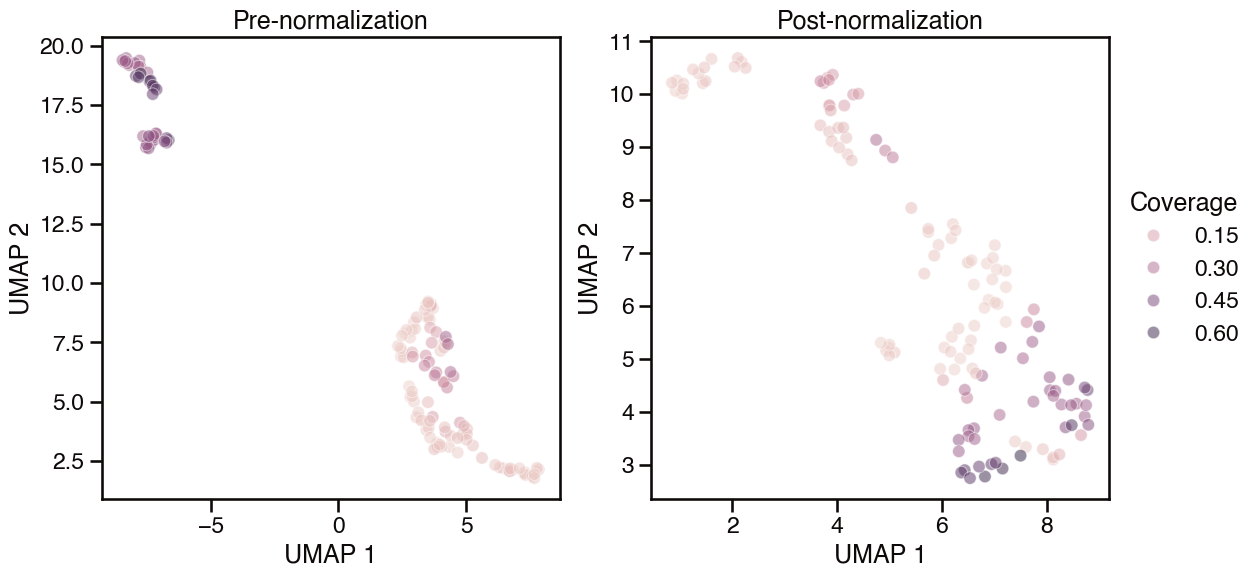


LLI


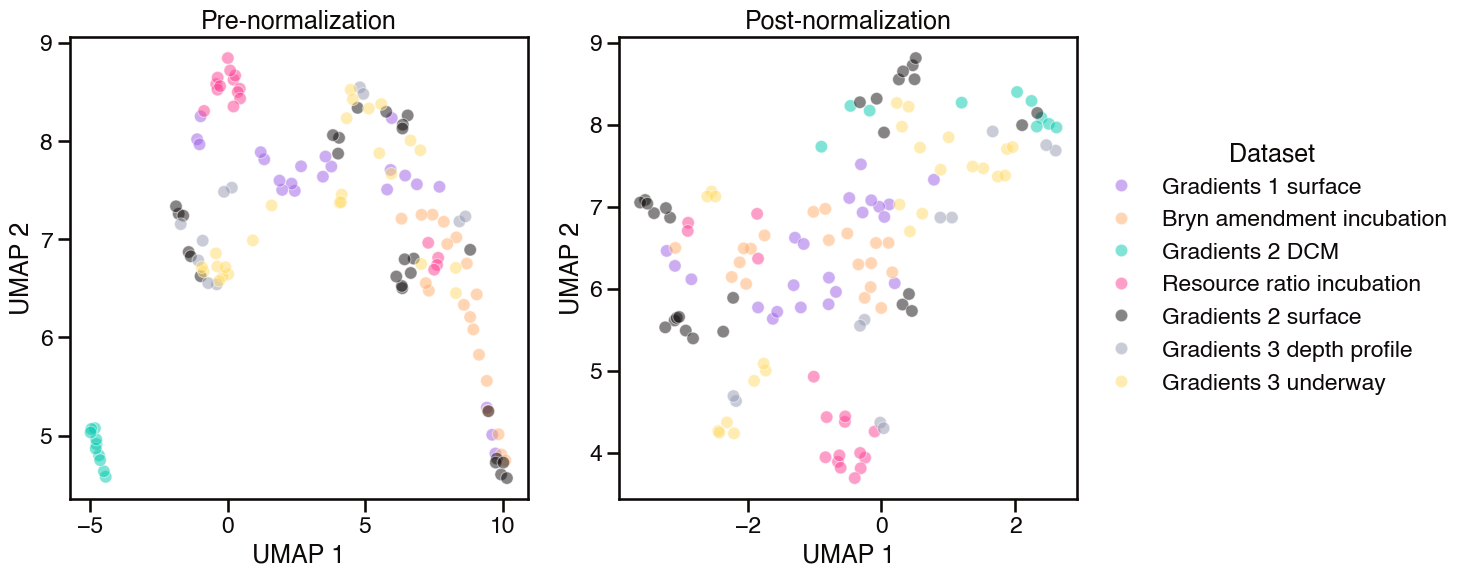

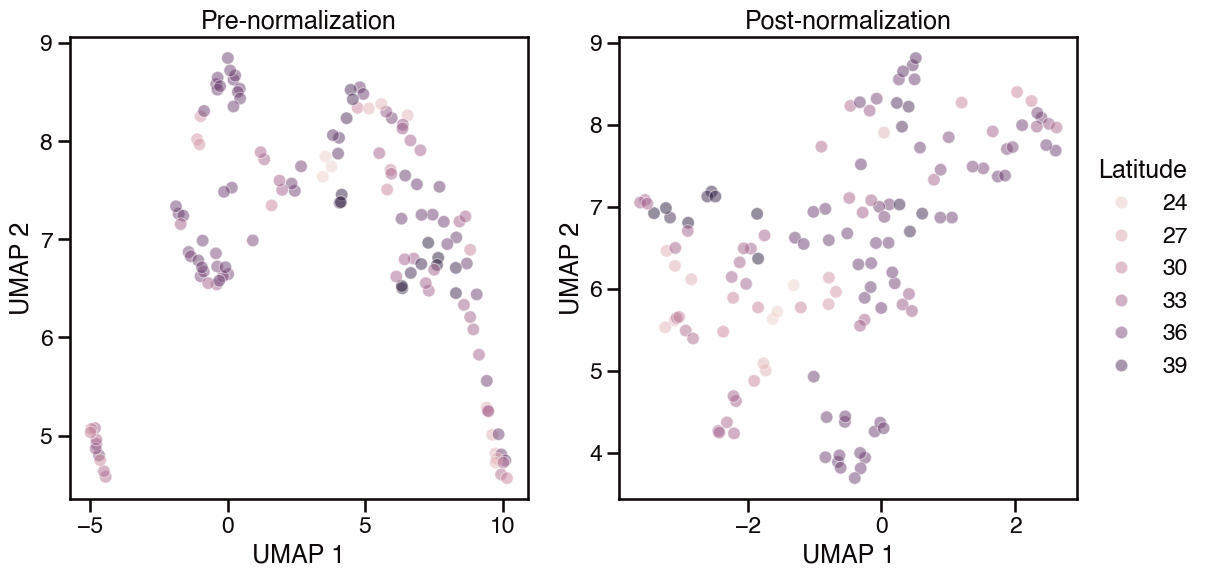

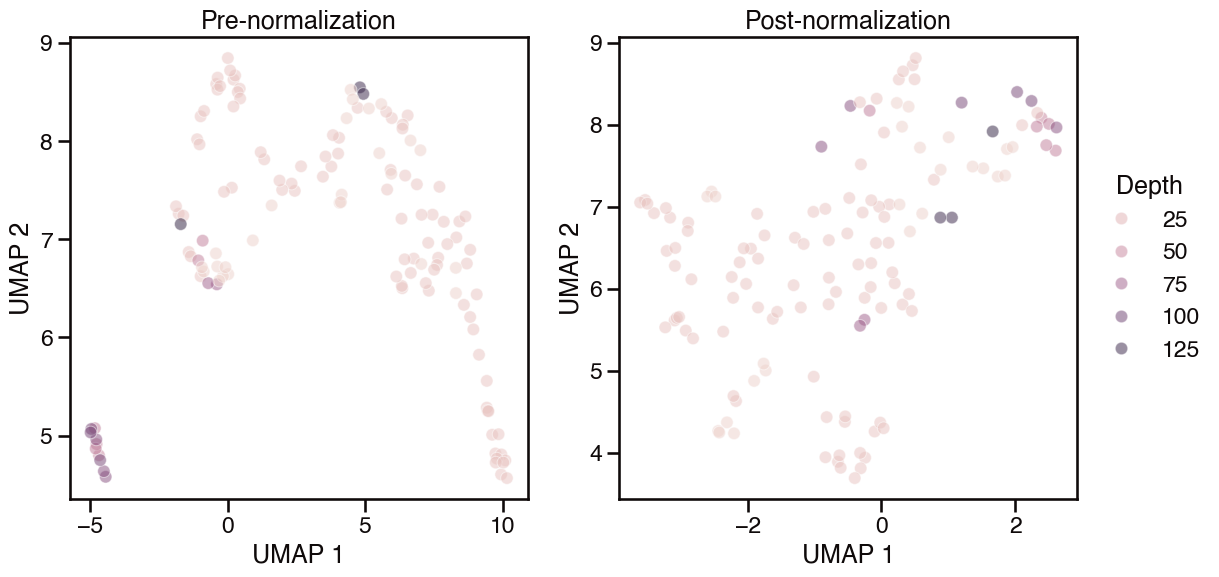

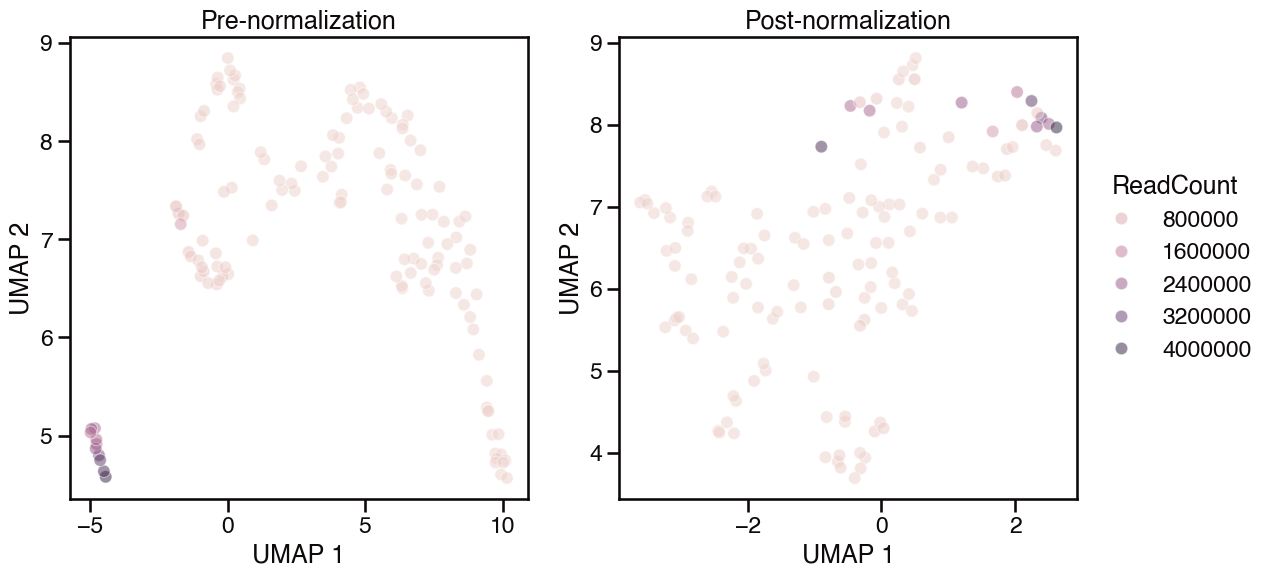

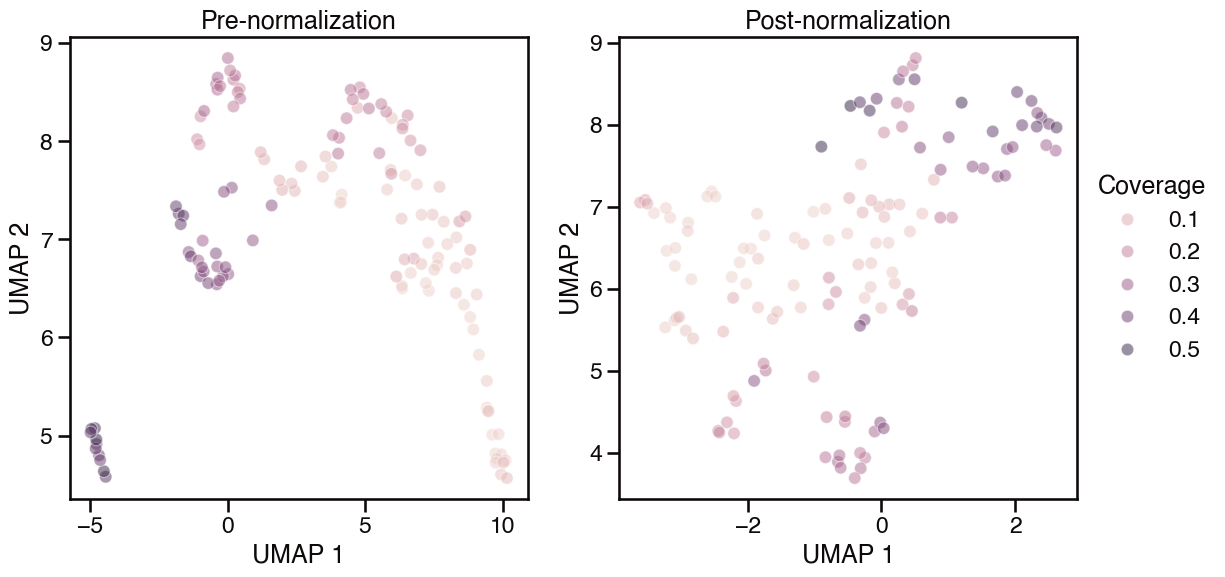


5.1A-CRD2


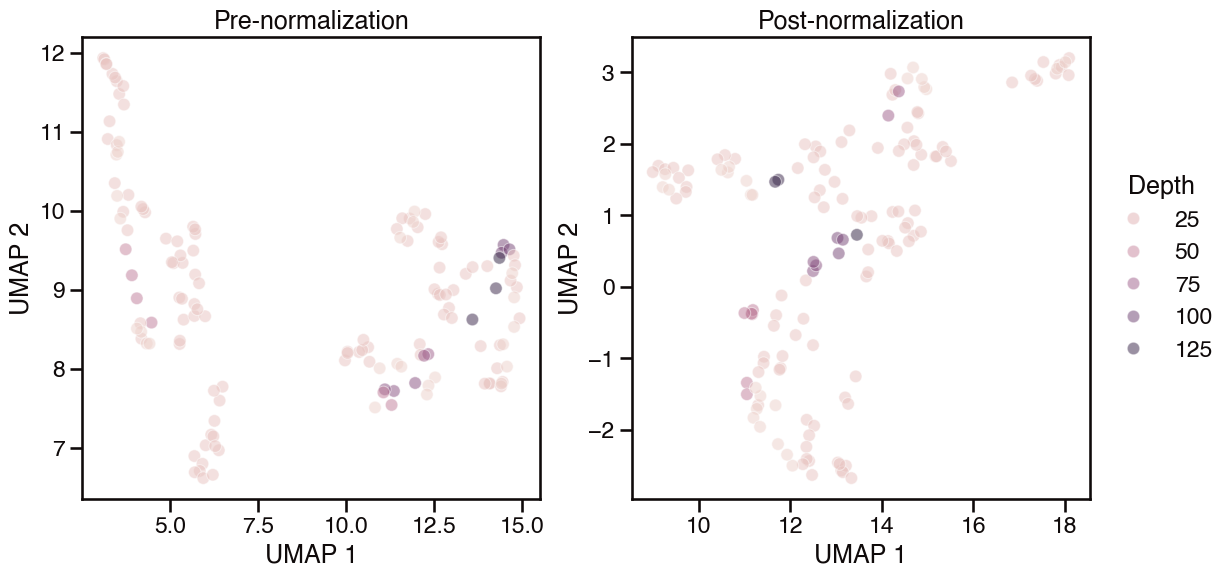

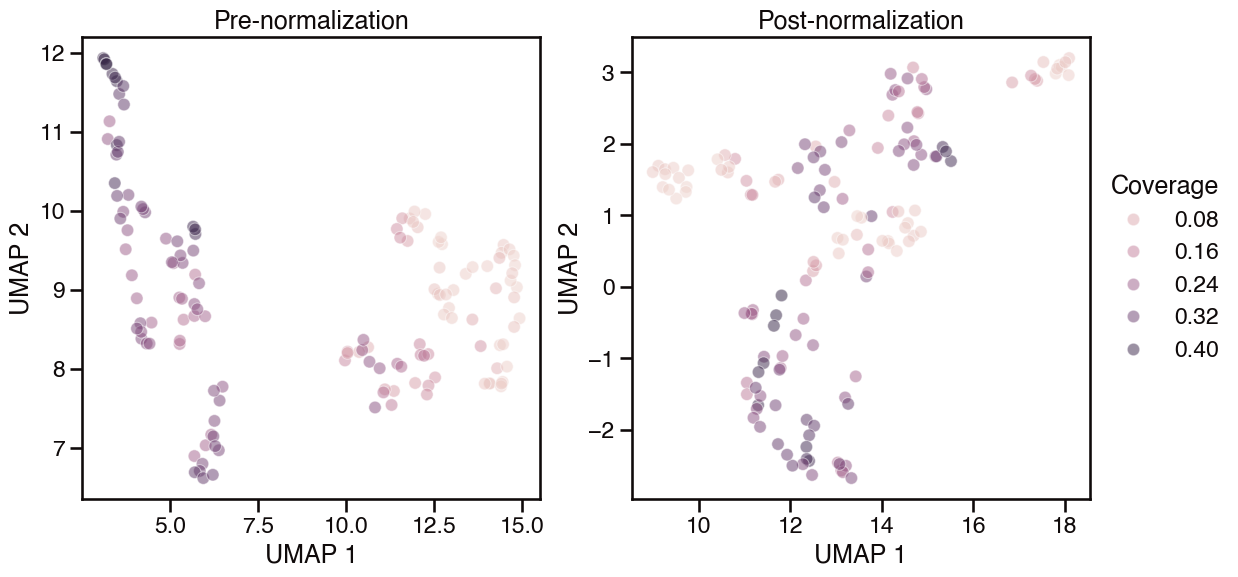


5.1A-II


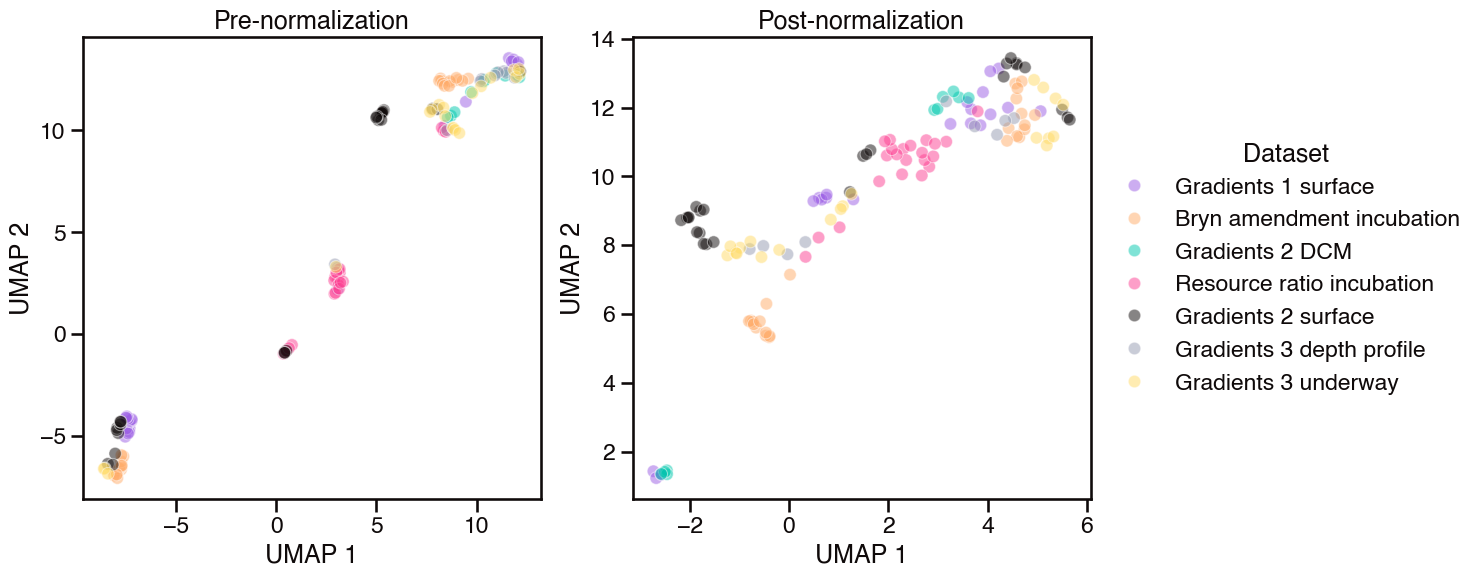

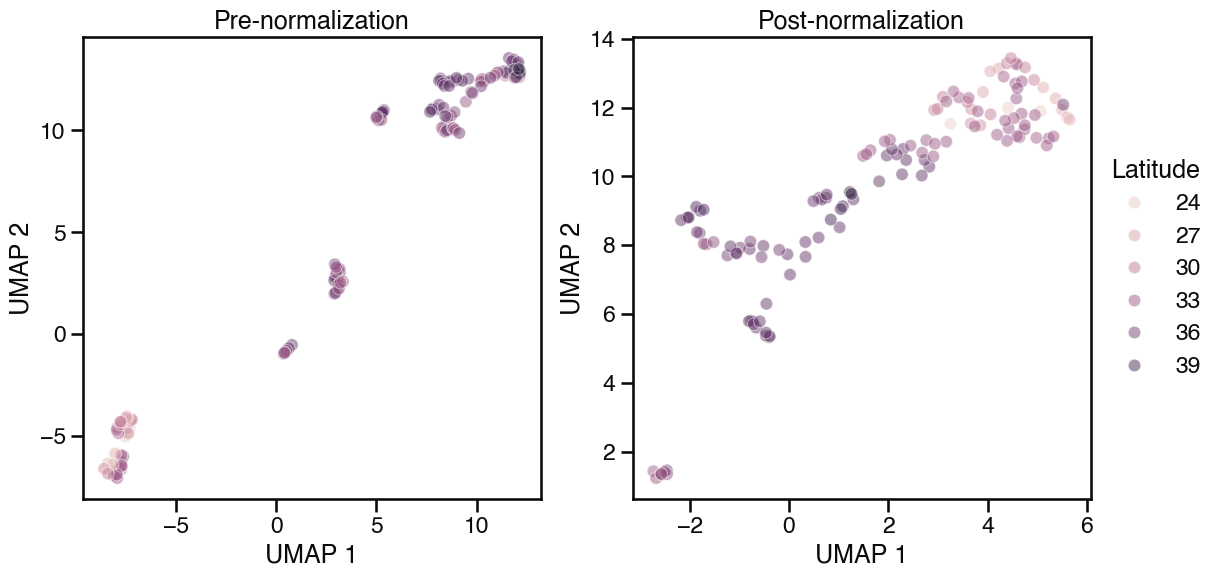

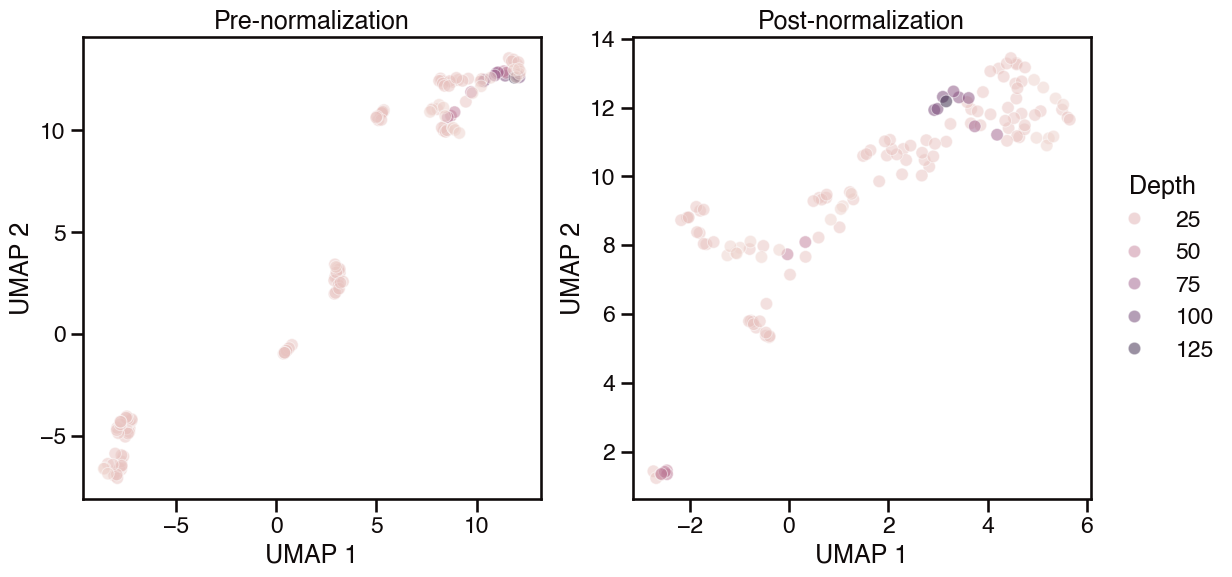

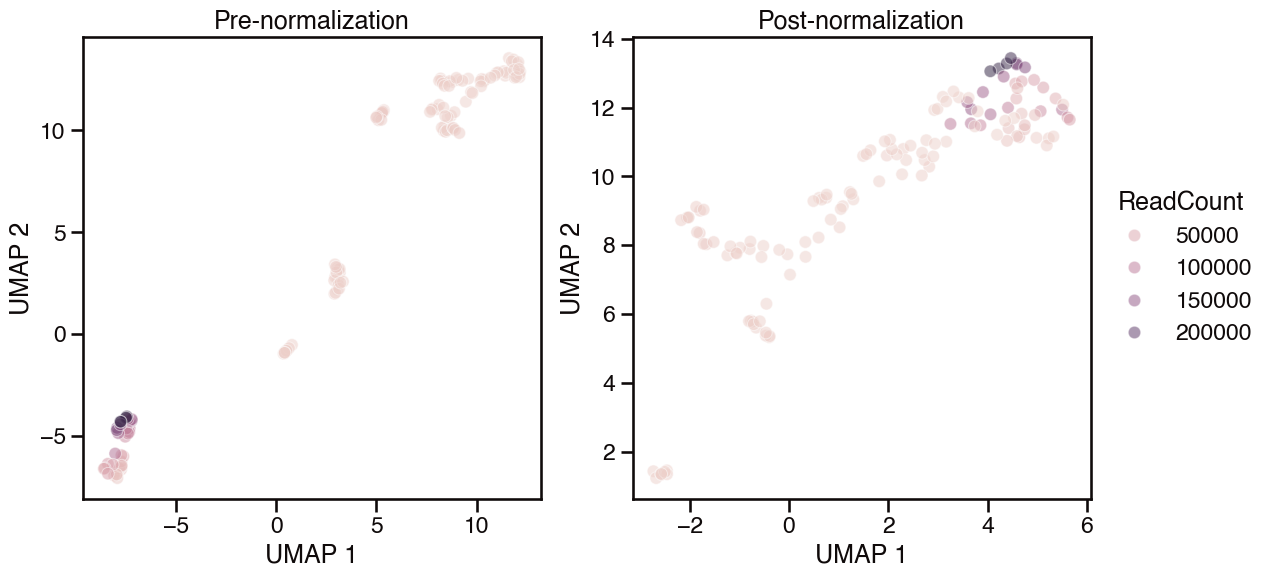

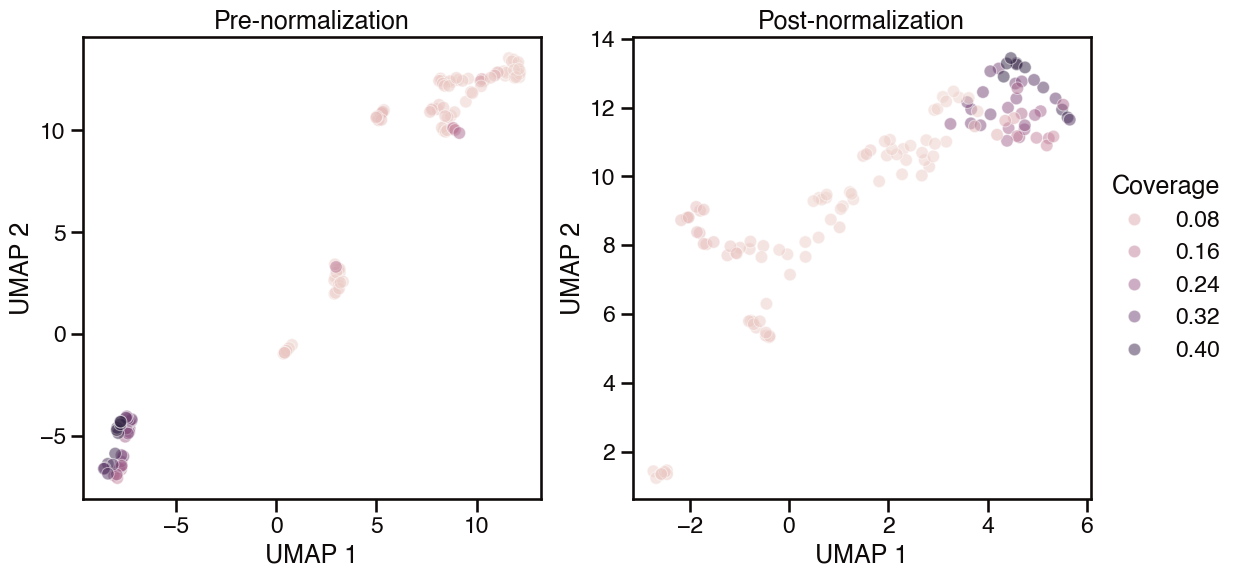


5.1A-III


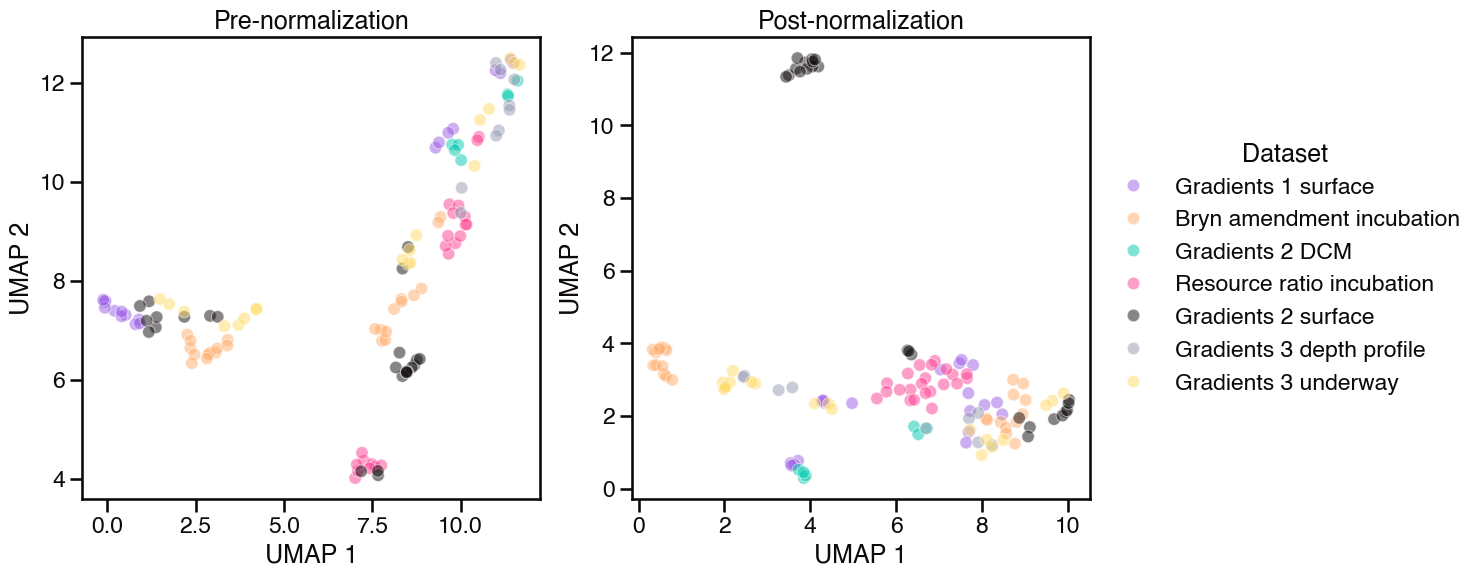

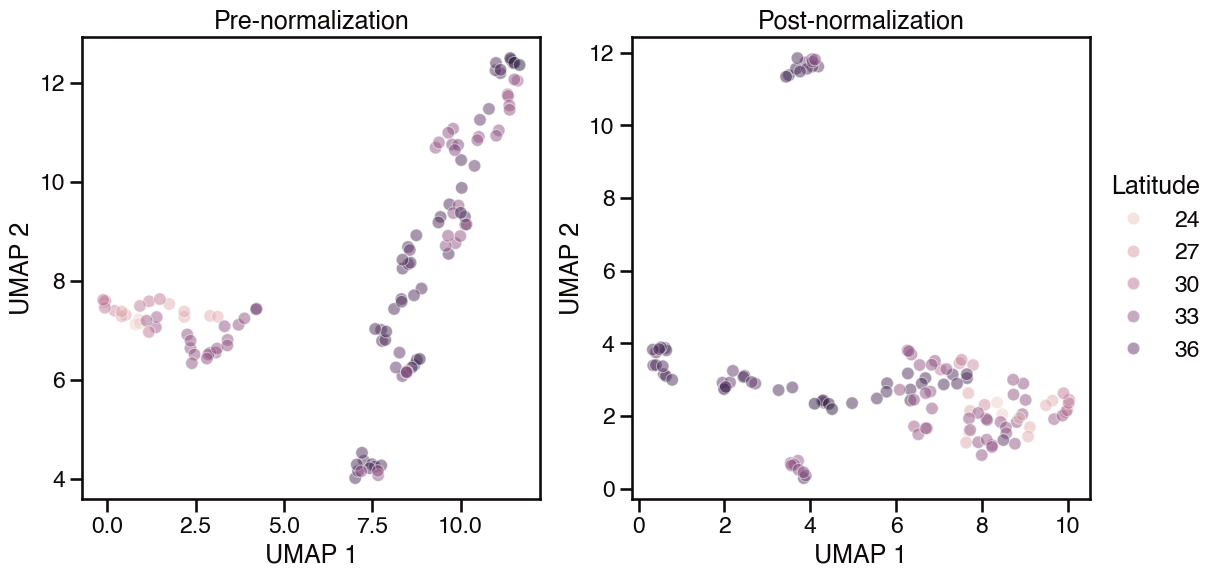

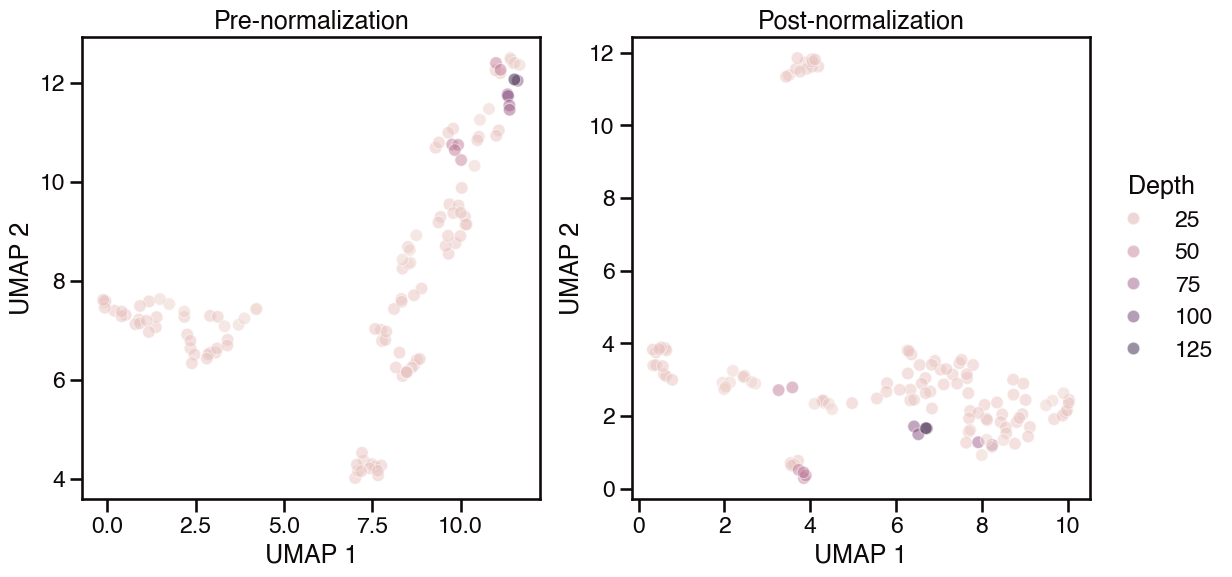

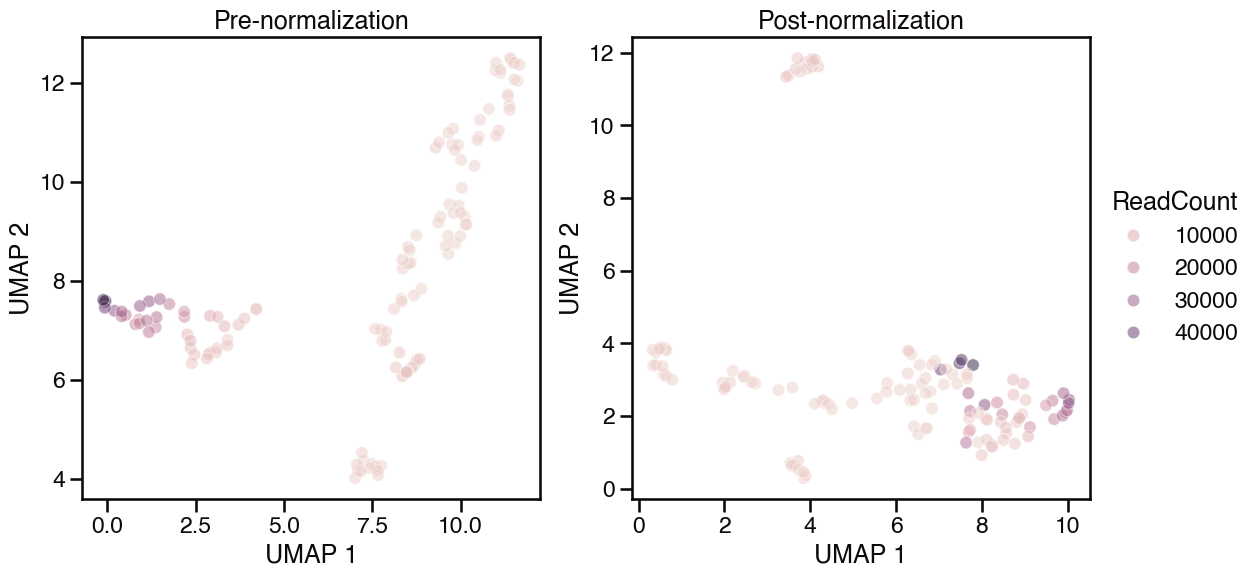


5.1A-IV


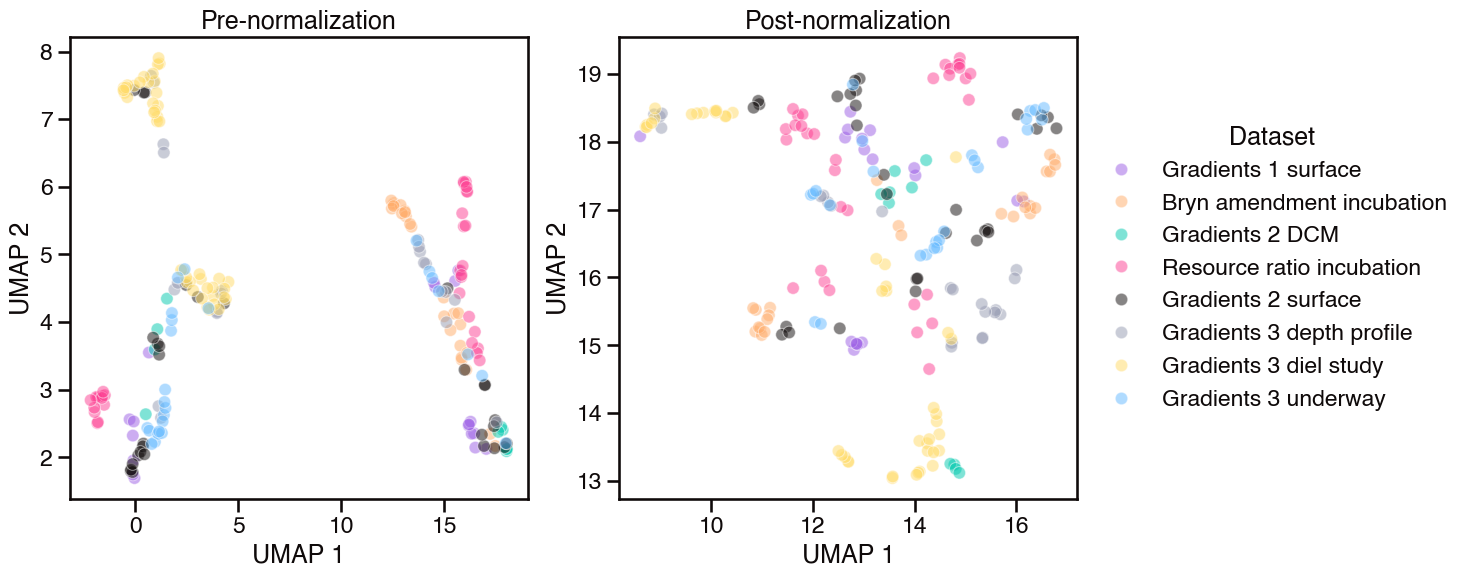

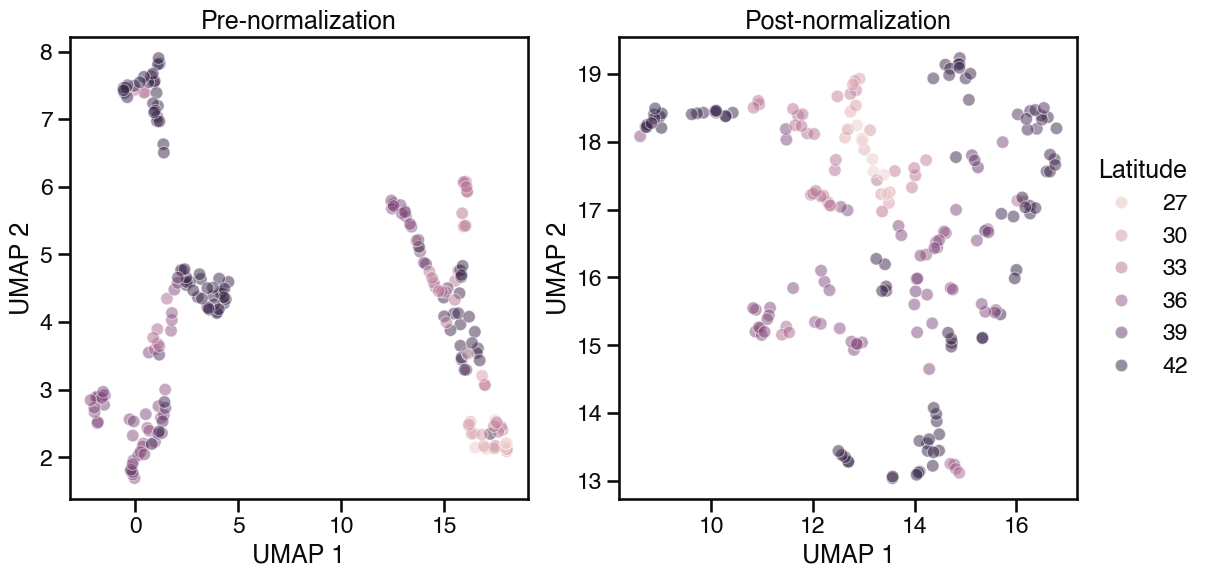

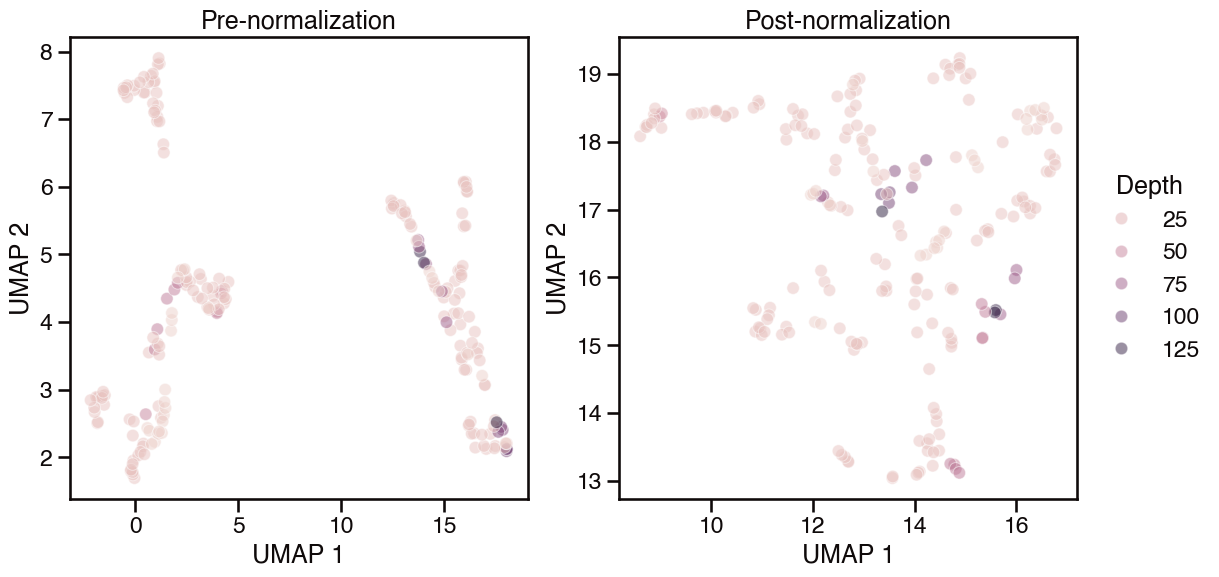

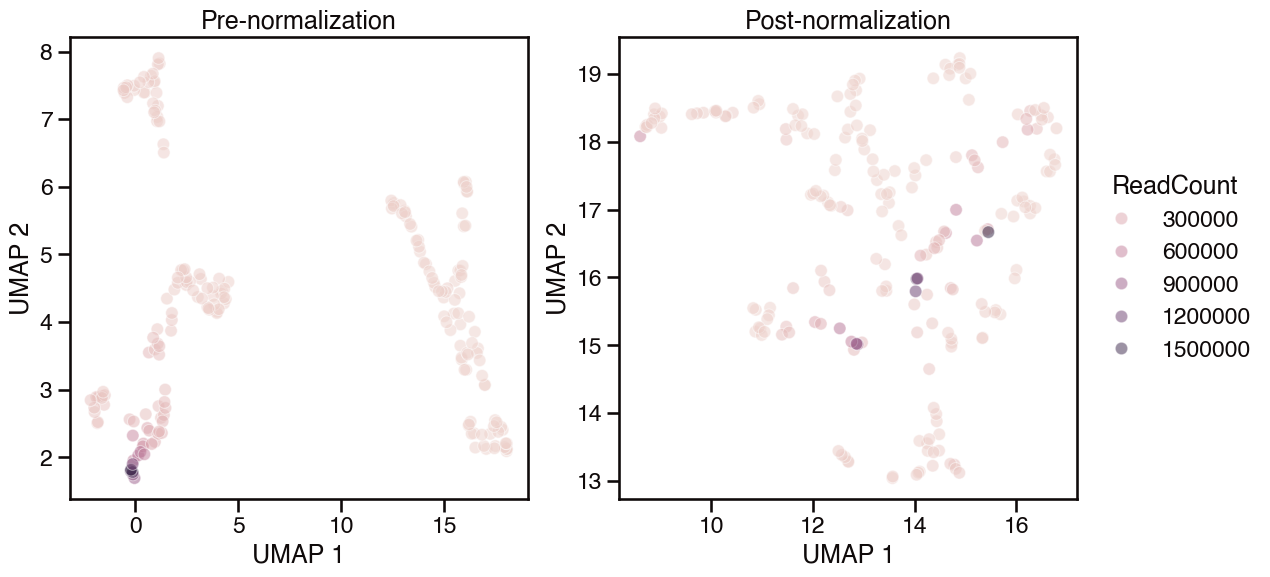

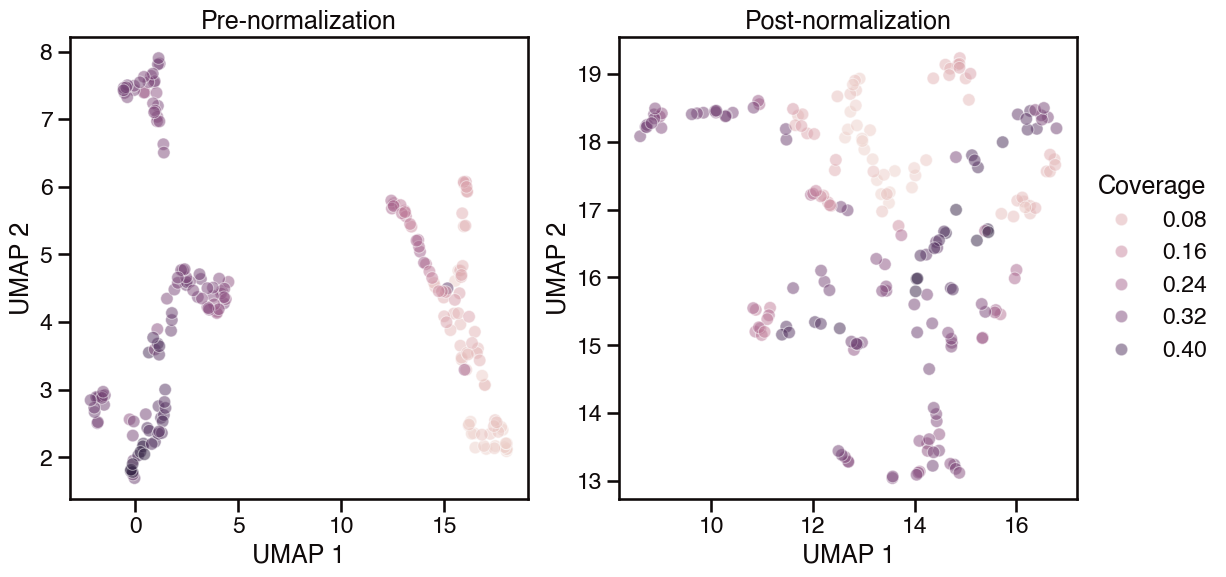


5.1A-UC-A-EnvC


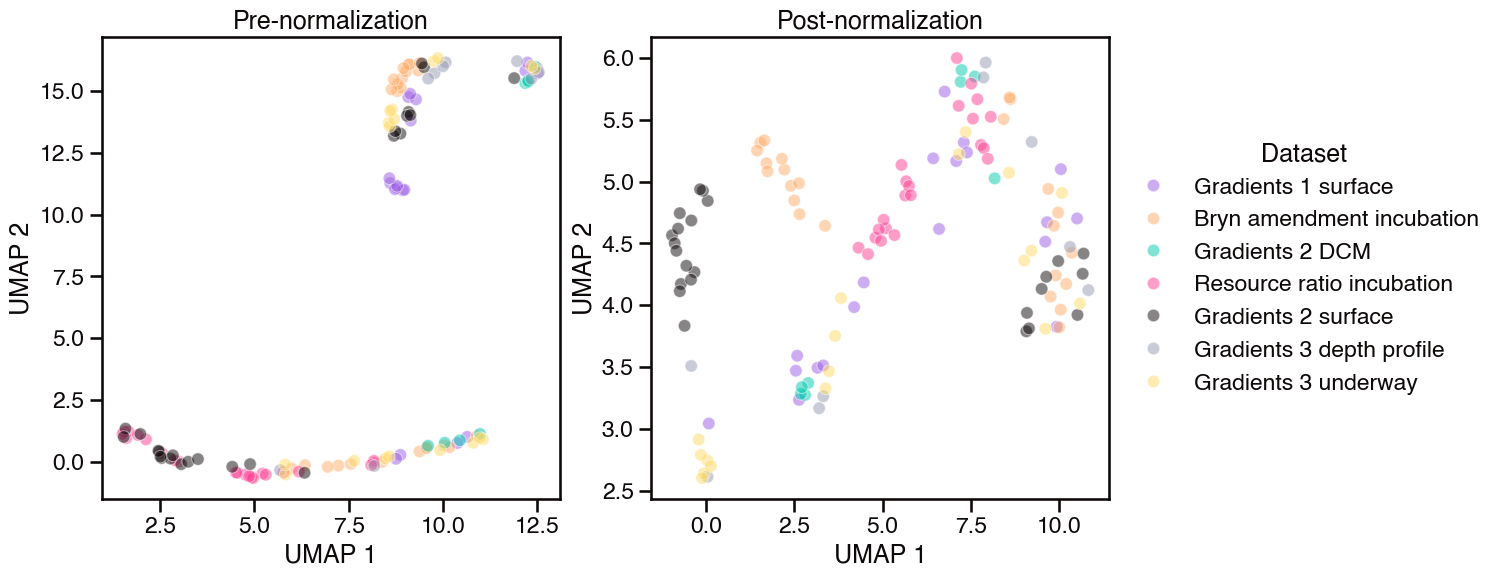

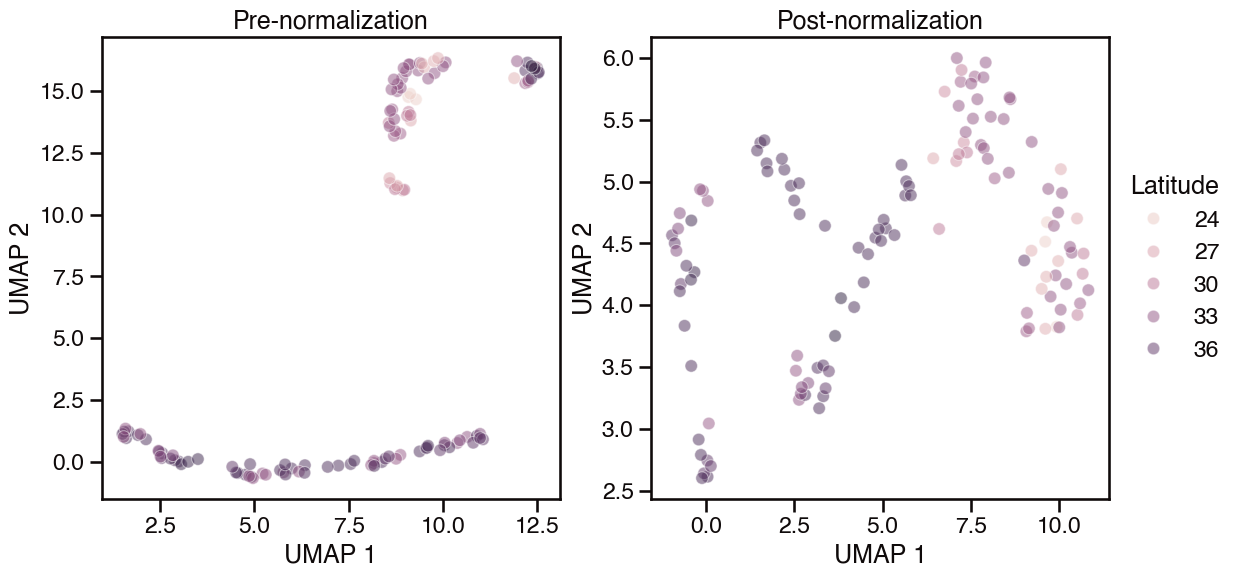

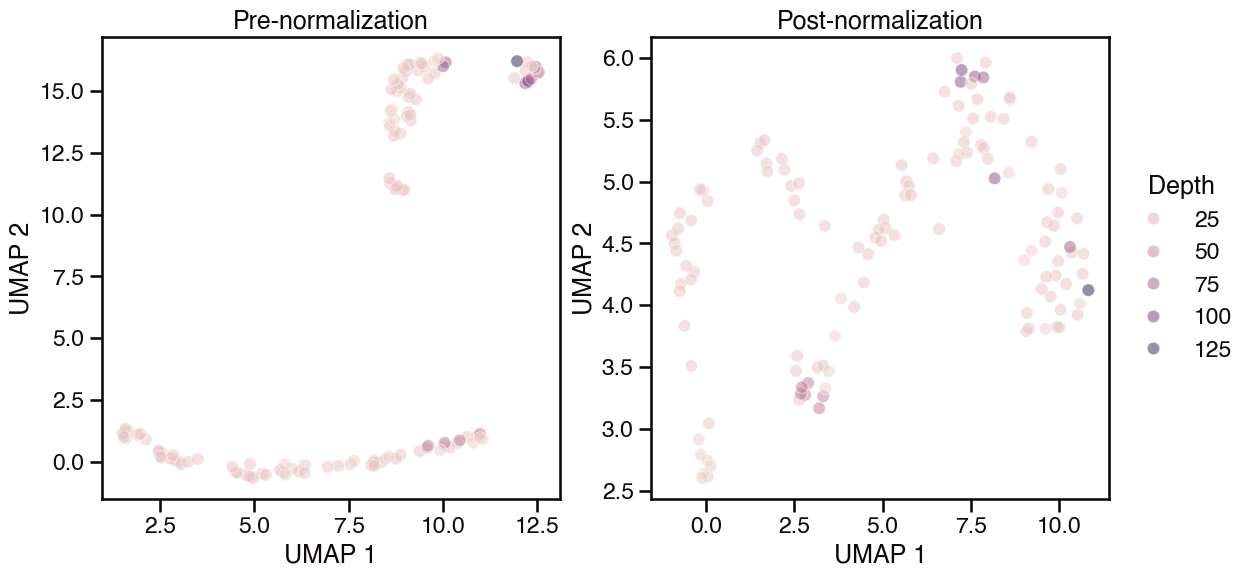


5.1B-CRD1


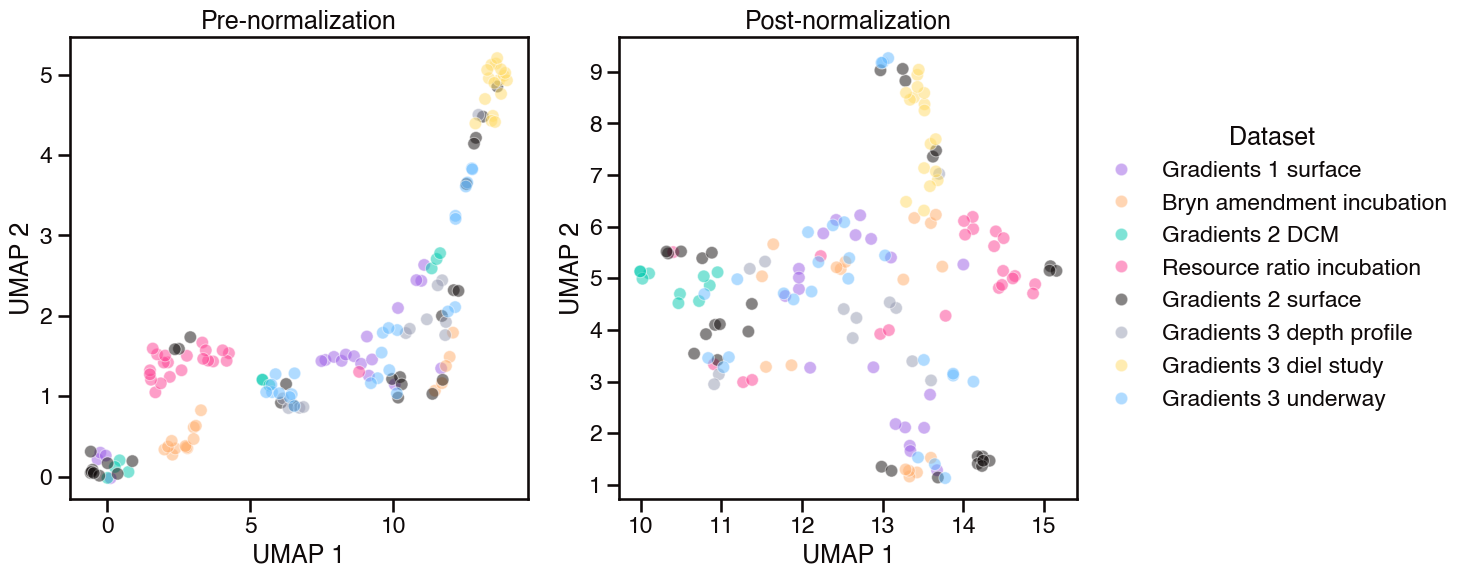

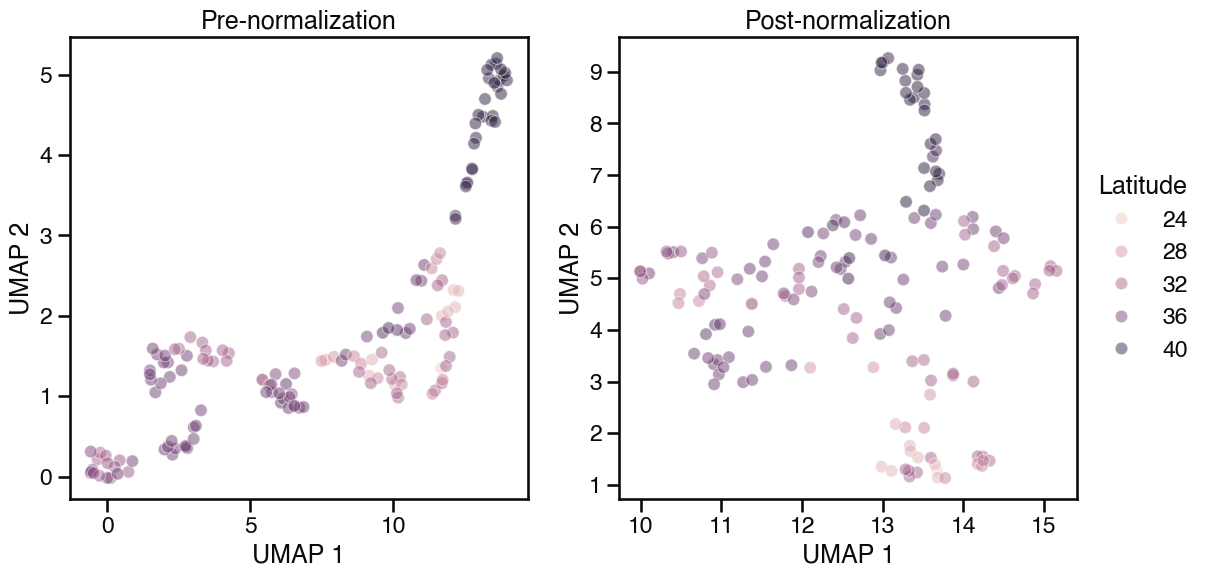

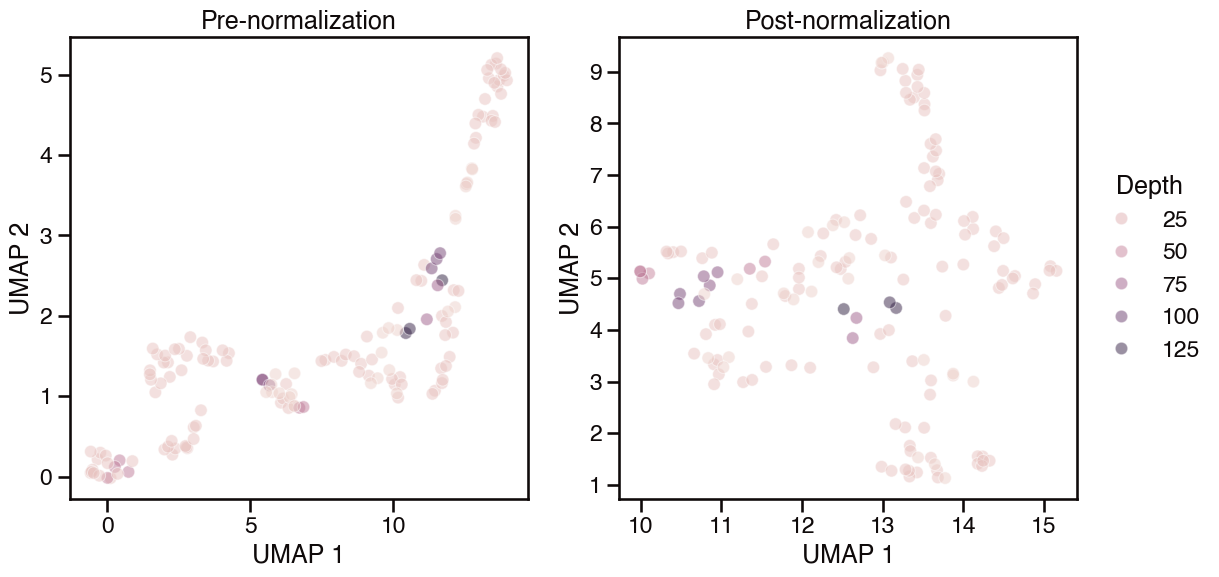

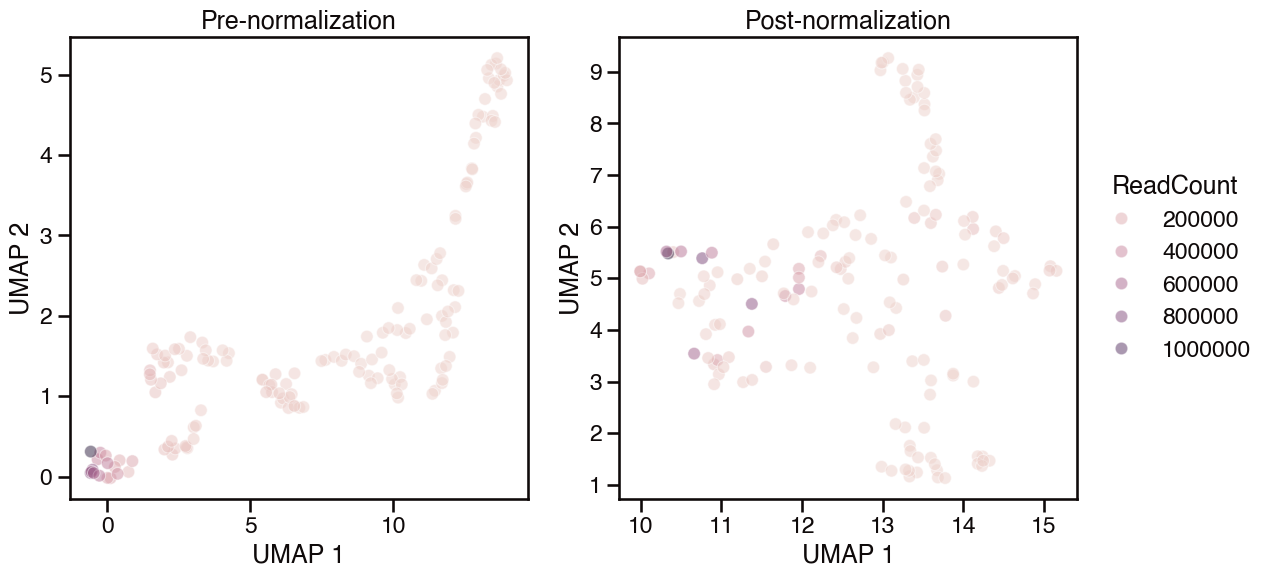

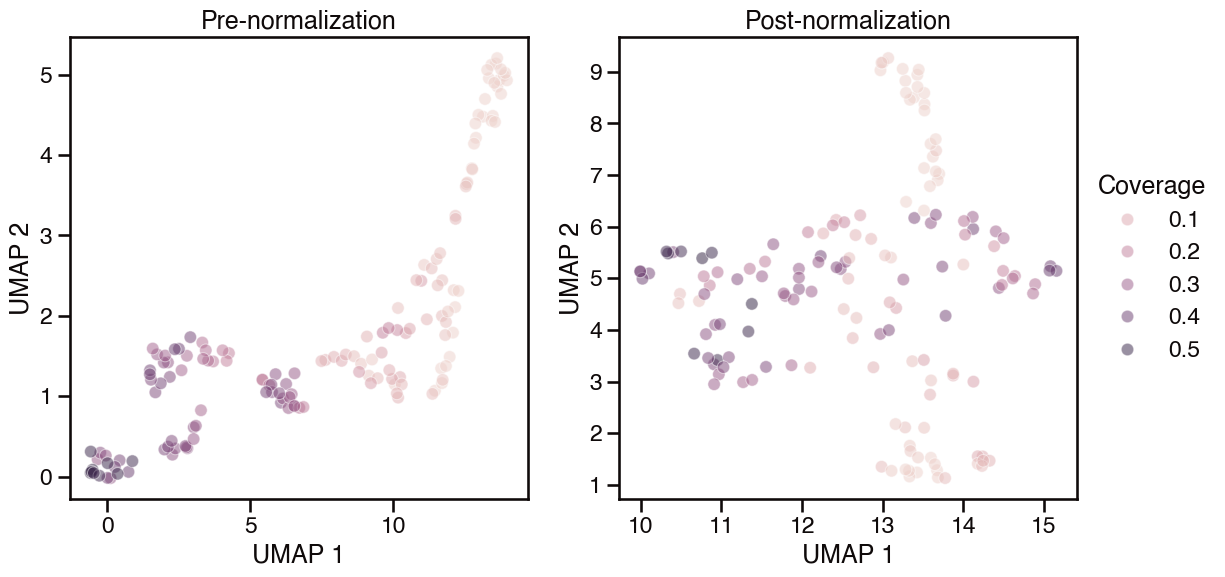


5.1B-I


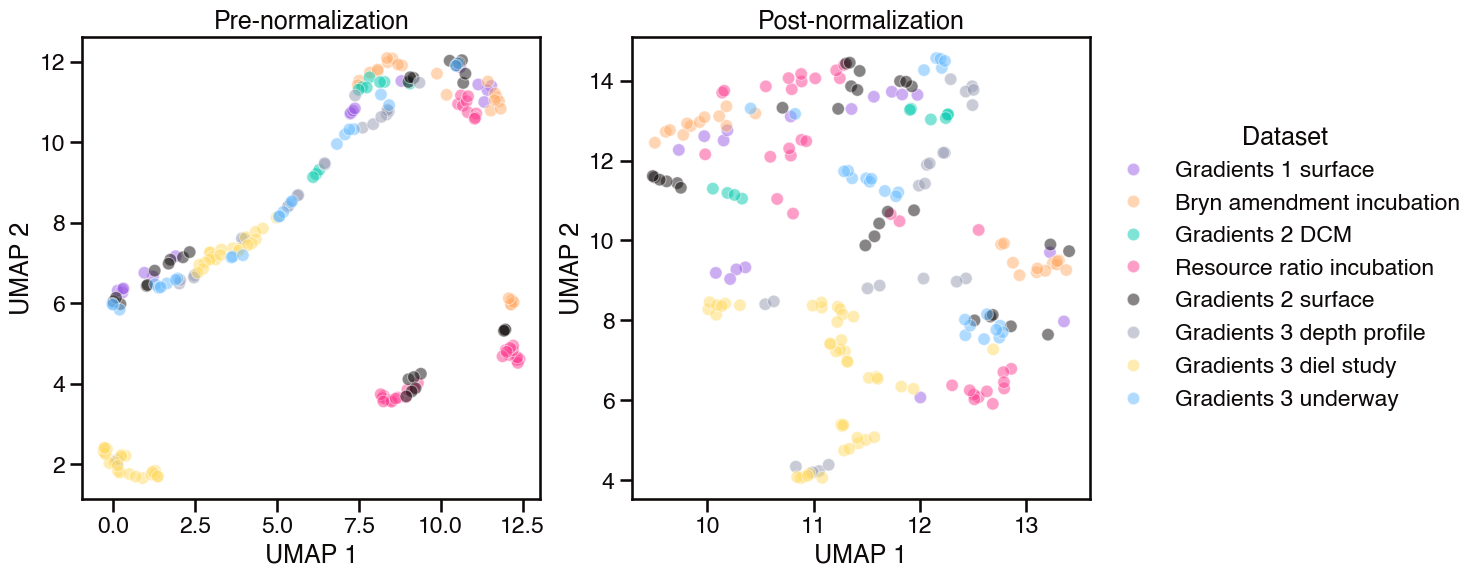

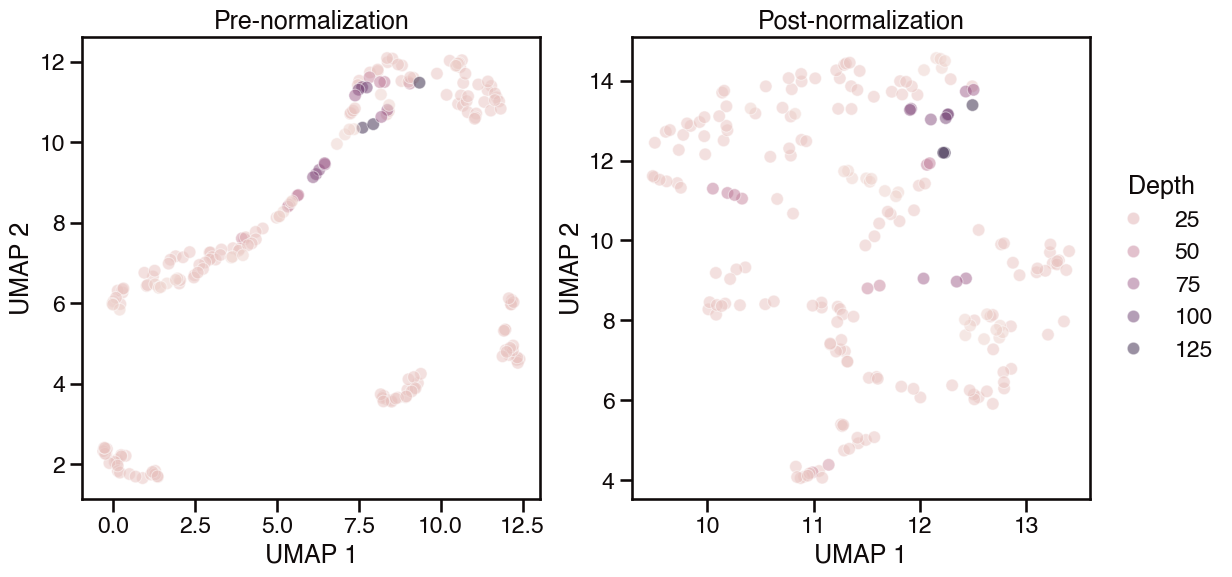

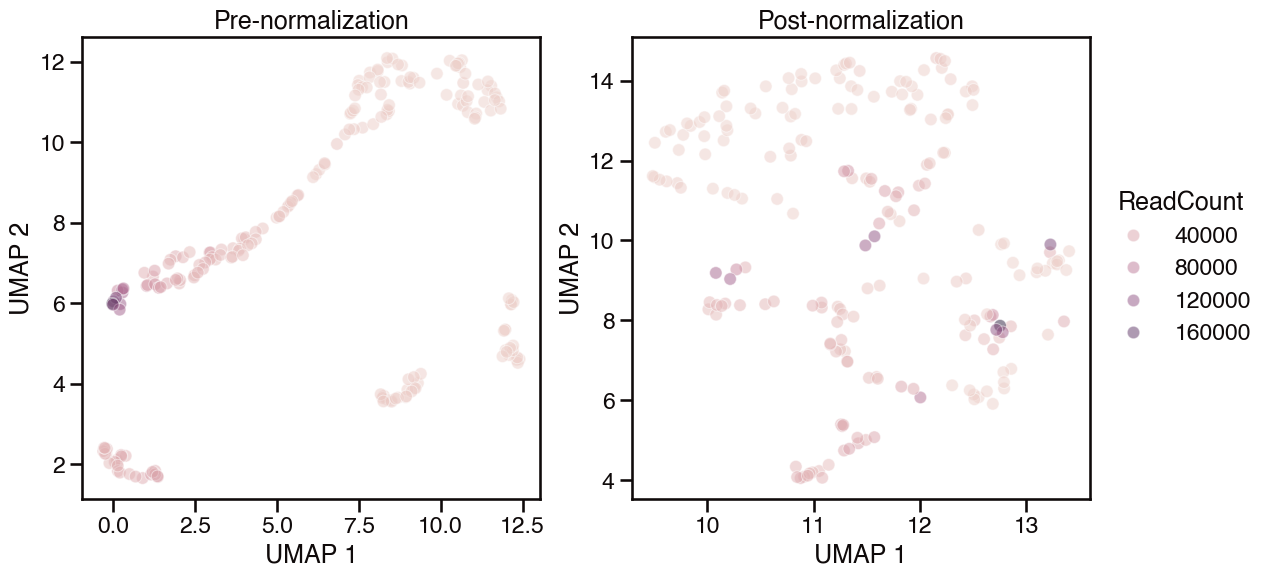

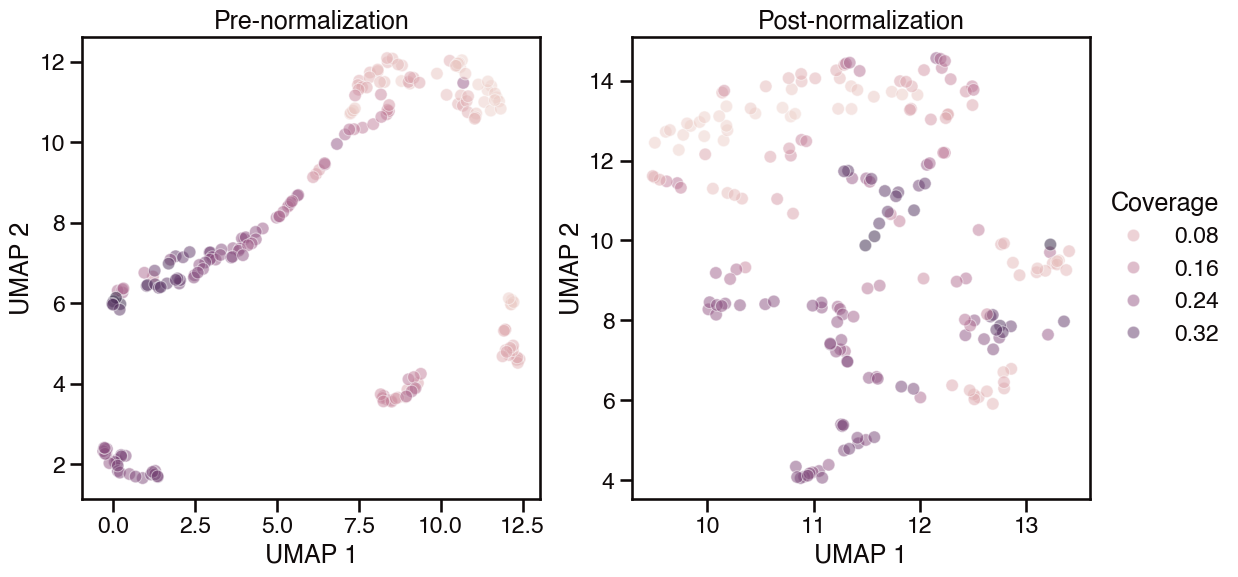

In [12]:
# plot dimensionality-reduced data

# variables = ['Cruise', 'Dataset', 'Latitude', 'Depth', 'replicate', 'Unfractionated']
variables = ['Dataset', 'Latitude', 'Depth', 'ReadCount', 'Coverage']

# plot both datasets
# for genus in ['pro', 'syn']:
#     print('\n{}\n'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[genus]))
#     plot_df = reduced_dfs[genus]
for clade in ['HLI', 'HLII', 'LLI', '5.1A-CRD2', '5.1A-II', '5.1A-III', '5.1A-IV', '5.1A-UC-A-EnvC', '5.1B-CRD1', '5.1B-I']:
# for clade in ['5.1A-I', '5.1A-II']:
    print('\n{}'.format(clade))
    plot_df = reduced_dfs[clade]

    # plot each variable
    for var in variables:
#         plt.plot()
        fig, axes = plt.subplots(1, 2, figsize=(13, 6))
        for i, dataset in enumerate(['Prenorm', 'Postnorm']):
            sns.scatterplot(x='{}0'.format(dataset), y='{}1'.format(dataset), hue=var, 
                            alpha=0.5, data=plot_df, ax=axes[i], legend={0: False, 1:'brief'}[i])
            axes[i].set(xlabel='UMAP 1', ylabel='UMAP 2', 
                     title={'Prenorm':'Pre-normalization', 'Postnorm':'Post-normalization'}[dataset])
            if i:
                axes[i].legend(title=var, loc='center left', bbox_to_anchor=[1, 0.5]);
#             plt.savefig('{}-residuals-umap-{}.png'.format(genus, var), bbox_inches='tight')
        plt.show()
#             fig.show()


# Look at specific genes

In [13]:
# summarize read count information

clade = 'HLII'
ds = pro_ds

# select gene data
readcount_df = ds.sel(Clade=clade).ReadCount.to_dataframe().reset_index()

# make sample summary df
sample_summary_df = readcount_df.groupby('Sample').agg(MeanReads=('ReadCount', 'mean'),
                                                       TotalReads=('ReadCount', 'sum'), 
                                                       GeomMeanReads=('ReadCount', geometric_mean))

# calculate scaling factor
mean_total_reads = sample_summary_df.TotalReads.mean()
sample_summary_df['ScalingFactor'] = sample_summary_df['TotalReads'] / mean_total_reads

# calculate logs
sample_summary_df = sample_summary_df[sample_summary_df['MeanReads'] != 0].reset_index()
sample_summary_df['LogMeanReads'] = np.log10(sample_summary_df['MeanReads'])
sample_summary_df['LogTotalReads'] = np.log10(sample_summary_df['TotalReads'])
sample_summary_df['LogGeomMeanReads'] = np.log10(sample_summary_df['GeomMeanReads'])

# add in sample info
sample_summary_df['Cruise'] = sample_summary_df['Sample'].map(sample_df.set_index('Sample')['Cruise'])
sample_summary_df['Dataset'] = sample_summary_df['Sample'].map(sample_df.set_index('Sample')['Dataset'])
sample_summary_df['Latitude'] = sample_summary_df['Sample'].map(sample_df.set_index('Sample')['Latitude'])

sample_summary_df


Sample    MeanReads   TotalReads  GeomMeanReads  \
0    G1.SURF.NS.S02C1.15m.A   839.009300  4214343.713       3.027389   
1    G1.SURF.NS.S02C1.15m.B  1550.683990  7789085.682       3.655718   
2    G1.SURF.NS.S02C1.15m.C  1349.536733  6778723.011       3.345661   
3    G1.SURF.NS.S04C1.15m.A   655.055010  3290341.316       2.335734   
4    G1.SURF.NS.S04C1.15m.B   529.673544  2660550.212       2.045470   
..                      ...          ...          ...            ...   
126    G3.UW.NS.UW37_1.7m.B     1.219487     6125.484       0.077717   
127    G3.UW.NS.UW37_1.7m.C     1.572224     7897.279       0.075992   
128    G3.UW.NS.UW38_1.7m.A     1.929078     9689.757       0.021460   
129    G3.UW.NS.UW38_1.7m.B     1.953775     9813.813       0.019346   
130    G3.UW.NS.UW38_1.7m.C     2.162927    10864.384       0.017037   

     ScalingFactor  LogMeanReads  LogTotalReads  LogGeomMeanReads Cruise  \
0         7.774141      2.923767       6.624730          0.481068     G1   
1        14.368418      3.190523       6.891486          0.562973     G1   
2        12.504616      3.130185       6.831148          0.524482     G1   
3         6.069647      2.816278       6.517241          0.368423     G1   
4         4.907880      2.724008       6.424971          0.310793     G1   
..             ...           ...            ...               ...    ...   
126       0.011300      0.086177       3.787140         -1.109483     G3   
127       0.014568      0.196514       3.897477         -1.119233     G3   
128       0.017875      0.285350       3.986313         -1.668380     G3   
129       0.018103      0.290875       3.991838         -1.713415     G3   
130       0.020041      0.335042       4.036005         -1.768598     G3   

                  Dataset   Latitude  
0     Gradients 1 surface  23.495833  
1     Gradients 1 surface  23.495833  
2     Gradients 1 surface  23.495833  
3     Gradients 1 surface  28.143167  
4     Gradients 1 surface  28.143167  
..                    ...        ...  
126  Gradients 3 underway  37.000000  
127  Gradients 3 underway  37.000000  
128  Gradients 3 underway  38.970000  
129  Gradients 3 underway  38.970000  
130  Gradients 3 underway  38.970000  

[131 rows x 11 columns]

In [14]:
# plot transcripts and abundances of a specific gene

# 60003709, 60001116
gene = 60001116
pseudocount = 1
# pseudocount = 1 / (10 * 4) # pro overdispersion factor

# pull out specific gene abundance
annotation = ds.sel(Clade=clade, Ortholog=gene).Annotation.data.flatten()[0]
gene_df = sample_summary_df.join(
    ds.sel(Clade=clade, Ortholog=gene).ReadCount.to_dataframe().ReadCount.rename('GeneReads'), 
    on='Sample'
)
gene_df = gene_df.join(
    ds.sel(Clade=clade, Ortholog=gene).Residual.to_dataframe().Residual.rename('Residual'), 
    on='Sample'
)
gene_df['LogGeneReads'] = np.log10(gene_df['GeneReads'] + pseudocount)
gene_df['LogNormedGeneReads'] = np.log(gene_df['GeneReads'] / gene_df['ScalingFactor'] + pseudocount)

# plot gene relationship
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
sns.scatterplot(
    x='LogTotalReads', 
    y='LogGeneReads', 
    hue='Dataset', 
    alpha=0.7, 
    data=gene_df, 
    ax=ax[0]
)
ax[0].set(
    xlabel='Organism Abundance\n(Log10 Total Reads)', 
    ylabel='Gene Abundance\n(Log10 Reads)', 
    title='{}: {}'.format(gene, annotation)
);
ax[0].legend(loc='center left', bbox_to_anchor=[1, 0.5]);
# plot residuals
sns.scatterplot(
    x='LogTotalReads', 
    y='Residual', 
    hue='Dataset', 
    alpha=0.7, 
    data=gene_df, 
    ax=ax[1]
)
ax[1].set(
    xlabel='Organism Abundance\n(Log10 Total Reads)', 
    ylabel='Residual Gene Abundance', 
);
ax[1].legend(loc='center left', bbox_to_anchor=[1, 0.5]);
# plot log norm
sns.scatterplot(
    x='LogTotalReads', 
    y='LogNormedGeneReads', 
    hue='Dataset', 
    alpha=0.7, 
    data=gene_df, 
    ax=ax[2]
)
ax[2].set(
    xlabel='Organism Abundance\n(Log10 Total Reads)', 
    ylabel='Log-Normalized Gene Abundance', 
);
ax[2].legend(loc='center left', bbox_to_anchor=[1, 0.5]);
fig.tight_layout()


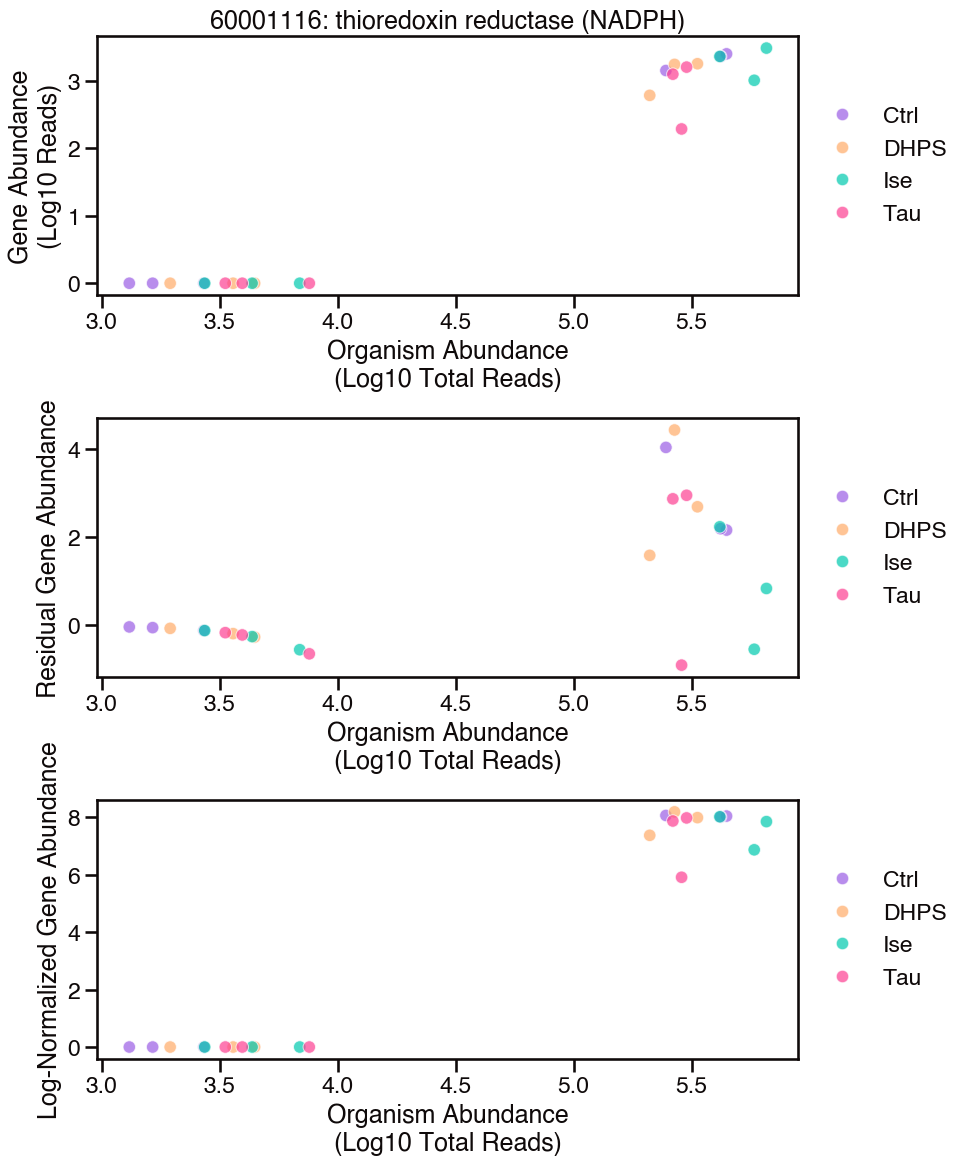

In [15]:
# plot incubation experiment residuals

gene_df = gene_df[gene_df['Dataset'] == 'Bryn amendment incubation']
gene_df['Experiment'] = gene_df['Sample'].map(sample_df.set_index('Sample')['Experiment'])
gene_df = gene_df.join(gene_df['Experiment'].str.split(' ', expand=True))

# plot gene relationship
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
sns.scatterplot(
    x='LogTotalReads', 
    y='LogGeneReads', 
    hue=1, 
    alpha=0.7, 
    data=gene_df, 
    ax=ax[0]
)
ax[0].set(
    xlabel='Organism Abundance\n(Log10 Total Reads)', 
    ylabel='Gene Abundance\n(Log10 Reads)', 
    title='{}: {}'.format(gene, annotation)
);
ax[0].legend(loc='center left', bbox_to_anchor=[1, 0.5]);
# plot residuals
sns.scatterplot(
    x='LogTotalReads', 
    y='Residual', 
    hue=1, 
    alpha=0.7, 
    data=gene_df, 
    ax=ax[1]
)
ax[1].set(
    xlabel='Organism Abundance\n(Log10 Total Reads)', 
    ylabel='Residual Gene Abundance', 
);
ax[1].legend(loc='center left', bbox_to_anchor=[1, 0.5]);
# plot log norm
sns.scatterplot(
    x='LogTotalReads', 
    y='LogNormedGeneReads', 
    hue=1, 
    alpha=0.7, 
    data=gene_df, 
    ax=ax[2]
)
ax[2].set(
    xlabel='Organism Abundance\n(Log10 Total Reads)', 
    ylabel='Log-Normalized Gene Abundance', 
);
ax[2].legend(loc='center left', bbox_to_anchor=[1, 0.5]);
fig.tight_layout()


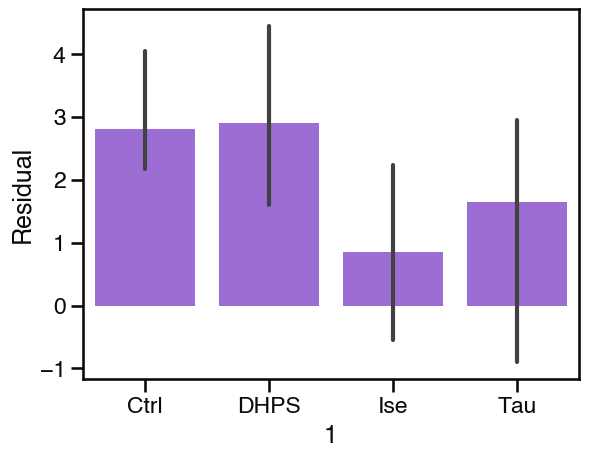

In [16]:
# compare conditions

sns.barplot(data=gene_df[gene_df[0] == 'BEXP3'], x=1, y='Residual'); 
